Step 1: Compute the brain-behaviour relationships using the full timeseries (i.e., no bootstrapping, no scrubbing) of the developmental sample so that we can treat this as the "ground truth" or baseline. Select the top 1% of the edges based on the significance of these relationships after correcting for multiple comparisons (p < 0.05 FDR).

In [2]:
epochs = 500
epochs.shape

AttributeError: 'int' object has no attribute 'shape'

In [1]:
#Date: 01/11/2021
#Authors: Jivesh Ramduny & Clare Kelly
#Location: Imaging Mind Architecture Lab, Trinity College Dublin

import os
import glob
import os.path as path
import pandas as pd
import numpy as np
import statsmodels.api as sm

#input directory for the 268 ROIs timeseries derived from Shen parcellation
rs_datapath = '/Users/jivesh/Downloads/TSFD004/*_HBN_268Parcels_rest_run_1.txt'
mv_datapath = '/Users/jivesh/Downloads/TSFD004/*_HBN_268Parcels_rest_run_2.txt'

rsfilename_list = np.sort(glob.glob(rs_datapath))
mvfilename_list = np.sort(glob.glob(mv_datapath))

#initialise an empty list to store all subjects timeseries for Sessions 1
rs_non_zero_roi = []
rsfMRI_timeseries = []
rsfMRI_timeseries_2d = []
rsfMRI_timeseries_corr = []

#initialise an empty list to store all subjects timeseries for Sessions 2
mv_non_zero_roi = []
mvfMRI_timeseries = []
mvfMRI_timeseries_2d = []
mvfMRI_timeseries_corr = []

rssubj_exclusion = []
mvsubj_exclusion = []
all_unique_contaminated_indices = []
mvall_unique_contaminated_indices = []

best_timepoints_size_s1 = []
best_timepoints_size_s2 = []

#iterate through the ROIs timeseries of each subject for Session 1
for rsfilename in rsfilename_list:

    rs_corr_shen = np.transpose(np.loadtxt(rsfilename))
    #append the ROI timeseries for each subject to a list
    rsfMRI_timeseries.append(rs_corr_shen)
    #find the subject-wise indices whose ROI timeseries have a value of 0
    rs_non_zero = np.where(np.any(rs_corr_shen == 0, axis = 1))
    #append the subject-wise indices to a list
    rs_non_zero_roi = np.concatenate((rs_non_zero_roi, rs_non_zero), axis = None)

#convert the appended list of all the subjects' timeseries to an array
rsfMRI_timeseries_to_array = np.asarray(rsfMRI_timeseries)

#iterate through the ROIs timeseries of each subject for Session 2
for mvfilename in mvfilename_list:

    mv_corr_shen = np.transpose(np.loadtxt(mvfilename))
    #append the ROI timeseries for each subject to a list
    mvfMRI_timeseries.append(mv_corr_shen)
    #find the subject-wise indices whose ROI timeseries have a value of 0
    mv_non_zero = np.where(np.any(mv_corr_shen == 0, axis = 1))
    #append the subject-wise indices to a list
    mv_non_zero_roi = np.concatenate((mv_non_zero_roi, mv_non_zero), axis = None)

#convert the appended list of all the subjects' timeseries to an array
mvfMRI_timeseries_to_array = np.asarray(mvfMRI_timeseries)

#append all subject-wise indices whose ROI timeseries contain a value of 0 for Session 1 & 2
all_indices_s1_s2 = np.concatenate((rs_non_zero_roi, mv_non_zero_roi), axis = None)
#find all the unique indices whose ROI timeseries contain a value of 0
find_unique_indices = np.unique(all_indices_s1_s2)
find_unique_indices_int = find_unique_indices.astype(int)

#remove all the rows whose ROI timseries contain a value of 0 based on the list of unique indices for Session 1
rsfMRI_nonzero_timeseries = np.delete(rsfMRI_timeseries_to_array, find_unique_indices_int, axis = 1)
#sanity check to verify the content and size of the resulting nonzero ROI timeseries
print(rsfMRI_nonzero_timeseries.shape)

#remove all the rows whose ROI timseries contain a value of 0 based on the list of unique indices for Session 2
mvfMRI_nonzero_timeseries = np.delete(mvfMRI_timeseries_to_array, find_unique_indices_int, axis = 1)
#sanity check to verify the content and size of the resulting nonzero ROI timeseries
print(mvfMRI_nonzero_timeseries.shape)

for rs_sub in range(0, len(rsfilename_list)):

    #copy the subject-wise ROI timeseries to a temporary 2D array for Session 1
    rsfMRI_timeseries_2d = rsfMRI_nonzero_timeseries[rs_sub, :, :].copy()

    #compute Pearson's correlation coefficient for Session 1
    rsfMRI_corr = np.corrcoef(rsfMRI_timeseries_2d)

    #truncate correlation matrix to select upper triangular matrix for Session 1
    rsfMRI_corr_shen = rsfMRI_corr.shape[0]
    arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
    trunc_rsfMRI_corr_shen = rsfMRI_corr[arange_rsfMRI_corr, diag]

    #append the truncated correlation matrix of all subjects to the list
    rsfMRI_timeseries_corr.append(trunc_rsfMRI_corr_shen)

#convert the list to an array for Session 1
trunc_rsfMRI_corr_to_array = np.asarray(rsfMRI_timeseries_corr)

print(trunc_rsfMRI_corr_to_array.shape)

#within_session_FC = np.mean(np.array([trunc_rsfMRI_corr_to_array, trunc_mvfMRI_corr_to_array]), axis = 0)
within_session_rsFC = trunc_rsfMRI_corr_to_array


(114, 211, 375)
(114, 211, 375)
(114, 22155)


In [2]:
#load behavioural data such as SRS Total for all participants
behav_datapath = pd.read_csv('/Users/jivesh/Downloads/test_HBN207_FD004_info.csv', index_col = 'SUBID')

#sort the subjects in ascending order to match the order of the subjects' timeseries
behav_df = behav_datapath.sort_index().copy()


In [3]:
for mv_sub in range(0, len(mvfilename_list)):

    #copy the subject-wise ROI timeseries to a temporary 2D array for Session 2
    mvfMRI_timeseries_2d = mvfMRI_nonzero_timeseries[mv_sub, :, :].copy()

    #compute Pearson's correlation coefficient for Session 2
    mvfMRI_corr = np.corrcoef(mvfMRI_timeseries_2d)

    #truncate correlation matrix to select upper triangular matrix for Session 2
    mvfMRI_corr_shen = mvfMRI_corr.shape[0]
    arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
    trunc_mvfMRI_corr_shen = mvfMRI_corr[arange_mvfMRI_corr, diag]

    #append the truncated correlation matrix of all subjects to the list
    mvfMRI_timeseries_corr.append(trunc_mvfMRI_corr_shen)

#convert the list to an array for Session 1
trunc_mvfMRI_corr_to_array = np.asarray(mvfMRI_timeseries_corr)

print(trunc_mvfMRI_corr_to_array.shape)

#within_session_FC = np.mean(np.array([trunc_rsfMRI_corr_to_array, trunc_mvfMRI_corr_to_array]), axis = 0)
within_session_mvFC = trunc_mvfMRI_corr_to_array


(114, 22155)


In [4]:
#transpose the array to ease further computation for Session 1
trans_rsfMRI_corr = np.transpose(trunc_rsfMRI_corr_to_array)

#transpose the array to ease further computation for Session 2
trans_mvfMRI_corr = np.transpose(trunc_mvfMRI_corr_to_array)

#compute columnwise pearson's correlation matrix between Session 1 and Session 2
trans_rsfMRI_corr = (trans_rsfMRI_corr - trans_rsfMRI_corr.mean(axis = 0)) / trans_rsfMRI_corr.std(axis = 0)
trans_mvfMRI_corr = (trans_mvfMRI_corr - trans_mvfMRI_corr.mean(axis = 0)) / trans_mvfMRI_corr.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

#sanity check to verify the size and content of the correlation matrix
print(rs_mv_corr.shape); print(rs_mv_corr)

#extract the diagonal values of the final correlation matrix
diag = np.diag(rs_mv_corr)

#extract the maximum value in each row of the final correlation matrix
max_corr = np.amax(rs_mv_corr, axis = 1)

#ID is based on a binary system where each diagonal value is compared with the
#maximum value of that row in the final correlation matrix. We expect that the
#diagnoal value is greater than or equal to the maximum value of each row to
#allow successful identification
diag_to_array = np.array(diag)
max_corr_to_array = np.array(max_corr)
BID = np.greater_equal(diag_to_array, max_corr_to_array)

print(BID)

#success rate is defined as the total number of positive identifications divided
#by the total number of subjects
success_rate_BID = np.sum(BID)/(BID.shape)
print(success_rate_BID)


(114, 114)
[[0.6103403  0.19170381 0.39970912 ... 0.31173062 0.4361274  0.39008818]
 [0.30620907 0.61111358 0.47098801 ... 0.33877897 0.42742422 0.41749255]
 [0.26047269 0.36727327 0.74633598 ... 0.34370308 0.41951081 0.46573201]
 ...
 [0.41594233 0.19978828 0.40005342 ... 0.6508089  0.51190889 0.47098813]
 [0.44822014 0.19887147 0.4018118  ... 0.35048214 0.66423748 0.44920666]
 [0.41820658 0.17877732 0.34719254 ... 0.34624266 0.40166408 0.57981052]]
[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True False  True  True  True False False  True
 False  True False False  True False False  True  True  True False False
  True False  True False False  True False  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True False  True
 False  True False  True False  Tr

/Users/jivesh/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.11, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


ShapiroResult(statistic=0.9433141350746155, pvalue=0.0001105294213630259)
ShapiroResult(statistic=0.8911478519439697, pvalue=1.292685567477747e-07)
ShapiroResult(statistic=0.9433141350746155, pvalue=0.0001105294213630259)
ShapiroResult(statistic=0.892041027545929, pvalue=1.4257931013617053e-07)
            n         r           CI95%        r2    adj_r2     p-val  \
spearman  114 -0.381645  [-0.53, -0.21]  0.145653  0.130259  0.000028   

             power  
spearman  0.989041  
            n        r          CI95%        r2    adj_r2     p-val     power
spearman  114 -0.34584  [-0.5, -0.17]  0.119605  0.103742  0.000164  0.968222


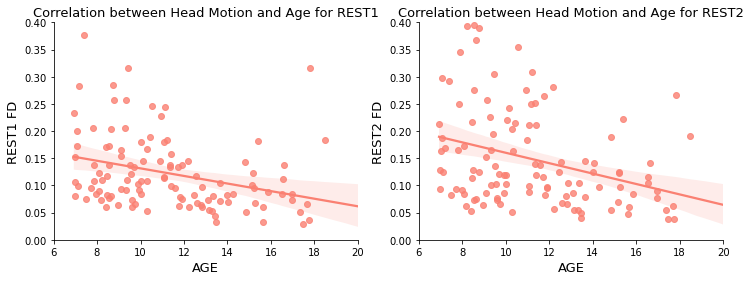

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats

plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
ax = sns.regplot(x = "AGE", y = "REST1_FD", data = behav_df, color = "salmon")

plt.xlim(6, 20)
plt.ylim(0, 0.4)
plt.xlabel("AGE", size = 13)
plt.ylabel("REST1 FD", size = 13)
plt.title("Correlation between Head Motion and Age for REST1", size = 13)

#check normality of the behavioural measures
print(scipy.stats.shapiro(behav_df["AGE"]))
print(scipy.stats.shapiro(behav_df["REST1_FD"]))

plt.subplot(1, 2, 2)
ax = sns.regplot(x = "AGE", y = "REST2_FD", data = behav_df, color = "salmon")

plt.xlim(6, 20)
plt.ylim(0, 0.4)
plt.xlabel("AGE", size = 13)
plt.ylabel("REST2 FD", size = 13)
plt.title("Correlation between Head Motion and Age for REST2", size = 13)

sns.despine()

#check normality of the behavioural measures
print(scipy.stats.shapiro(behav_df["AGE"]))
print(scipy.stats.shapiro(behav_df["REST2_FD"]))

#Spearman's Rank between head motion and age
REST1 = pg.corr(x = behav_df['AGE'], y = behav_df['REST1_FD'], method = "spearman")
REST2 = pg.corr(x = behav_df['AGE'], y = behav_df['REST2_FD'], method = "spearman")

print(REST1)
print(REST2)


In [5]:
model_pval = []
model_coef = []

for edge in range(0, within_session_rsFC.shape[1]):
    
    behav_df['FC'] = within_session_rsFC[:, edge]
    model = pg.partial_corr(data = behav_df, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model_pval.append(model['p-val'])
    model_coef.append(model['r'])


In [6]:
import statsmodels.stats.multitest as mc
corr_pval = mc.multipletests(np.array(model_pval).flatten(), alpha = 0.05, method = 'fdr_bh')
corr_pval


(array([False, False, False, ..., False, False, False]),
 array([0.89704032, 0.8367839 , 0.9367212 , ..., 0.64153076, 0.27414348,
        0.93814703]),
 2.315199052582706e-06,
 2.2568269013766643e-06)

In [7]:
pcorr_indices = np.where(corr_pval[1] <= 0.05)
np.array(pcorr_indices).shape[1]


11

In [8]:
model2_pval = []
model2_coef = []

REST2_edges = np.take(within_session_mvFC, pcorr_indices, axis = 1).squeeze()

for edge in range(0, REST2_edges.shape[1]):
    
    behav_df['FC'] = REST2_edges[:, edge]
    model2 = pg.partial_corr(data = behav_df, x = 'AGE', y = 'FC', covar = ['SEX', 'REST2_FD'], method = 'spearman')
    model2_pval.append(model2['p-val'])
    model2_coef.append(model2['r'])


In [9]:
REST1_coef = np.array(np.take(model_coef, pcorr_indices)).flatten()
REST2_coef = np.array(model2_coef).flatten()

pg.corr(x = REST1_coef, y = REST2_coef, method = "spearman")


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,11,0.545455,"[-0.08, 0.86]",0.297521,0.121901,0.082651,0.435788


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,9,0.183333,"[-0.55, 0.76]",0.033611,-0.288519,0.63682,0.075524


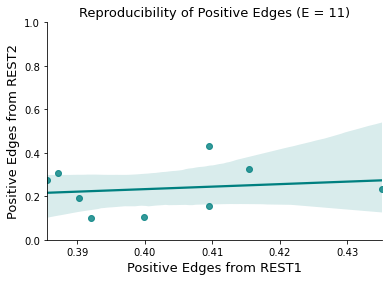

In [10]:
sns.regplot(x = REST1_coef[REST1_coef > 0], y = REST2_coef[REST2_coef > 0], color = 'teal')

plt.xlabel("Positive Edges from REST1", size = 13)
plt.ylabel("Positive Edges from REST2", size = 13)
plt.title("Reproducibility of Positive Edges (E = 11)", size = 13)
#plt.xlim(0.38, 0.5)
plt.ylim(0, 1)
sns.despine()

pg.corr(x = REST1_coef[REST1_coef > 0], y = REST2_coef[REST2_coef > 0], method = "spearman")


In [9]:
REST1_coef = np.array(np.take(model_coef, pcorr_indices)).flatten()
REST1_pval = np.array(np.take(model_pval, pcorr_indices)).flatten()
max_corr_edge = REST1_coef.argmax()
max_corr_edge

best_edge = np.array(np.where(model_coef == REST1_coef[max_corr_edge])).squeeze()[0]
best_edge


12057

In [10]:
numROI = rsfMRI_nonzero_timeseries.shape[1]

A = np.arange(numROI * numROI).reshape(numROI, numROI)
A2 = np.arange(numROI * numROI).reshape(numROI, numROI)
np.fill_diagonal(A, 1)

B = A[np.triu_indices(numROI, k = 1)]
ROI_dimx = np.where(A2 == B[best_edge])
rsfMRI_bestroi_nonzero_timeseries = np.take(rsfMRI_nonzero_timeseries, ROI_dimx, axis = 1).squeeze()
mvfMRI_bestroi_nonzero_timeseries = np.take(mvfMRI_nonzero_timeseries, ROI_dimx, axis = 1).squeeze()

print(A)
print(rsfMRI_bestroi_nonzero_timeseries.shape)
print(mvfMRI_bestroi_nonzero_timeseries.shape)


[[    1     1     2 ...   208   209   210]
 [  211     1   213 ...   419   420   421]
 [  422   423     1 ...   630   631   632]
 ...
 [43888 43889 43890 ...     1 44097 44098]
 [44099 44100 44101 ... 44307     1 44309]
 [44310 44311 44312 ... 44518 44519     1]]
(114, 2, 375)
(114, 2, 375)


In [22]:
#COMPUTE CONNECTIVITY FOR 2 ROIS ONLY

subjects = 114
epochs = 500

all_rssamples = []
all_mvsamples = []
edges = ((rsfMRI_bestroi_nonzero_timeseries.shape[1] * rsfMRI_bestroi_nonzero_timeseries.shape[1]) - rsfMRI_bestroi_nonzero_timeseries.shape[1]) // 2

rsbootstrap_rsfMRI_corr = np.zeros((epochs, subjects))
mvbootstrap_rsfMRI_corr = np.zeros((epochs, subjects))

for epoch in range(epochs):
    
    samples = np.random.choice(rsfMRI_bestroi_nonzero_timeseries.shape[0], subjects, replace = False)
    rsbootstrap_samples = np.take(rsfMRI_bestroi_nonzero_timeseries, samples, axis = 0)
    all_rssamples.append(samples)
    
    for sub_s1 in range(rsbootstrap_samples.shape[0]):
        rsbootstrap_timeseries_2d = rsbootstrap_samples[sub_s1, :, :].copy()
        rsbootstrap_corr_matrix = np.corrcoef(rsbootstrap_timeseries_2d)
        
        rsbootstrap_corr_shen = rsbootstrap_corr_matrix.shape[0]
        arange_rsbootstrap_corr, diag = np.triu_indices(rsbootstrap_corr_shen, 1)
        trunc_rsbootstrap_corr = rsbootstrap_corr_matrix[arange_rsbootstrap_corr, diag]
        rsbootstrap_rsfMRI_corr[epoch, sub_s1] = trunc_rsbootstrap_corr
        
for epoch in range(epochs):
    
    samples = np.random.choice(mvfMRI_bestroi_nonzero_timeseries.shape[0], subjects, replace = False)
    mvbootstrap_samples = np.take(mvfMRI_bestroi_nonzero_timeseries, samples, axis = 0)
    all_mvsamples.append(samples)
    
    for sub_s2 in range(mvbootstrap_samples.shape[0]):
        mvbootstrap_timeseries_2d = mvbootstrap_samples[sub_s2, :, :].copy()
        mvbootstrap_corr_matrix = np.corrcoef(mvbootstrap_timeseries_2d)
        
        mvbootstrap_corr_shen = mvbootstrap_corr_matrix.shape[0]
        arange_mvbootstrap_corr, diag = np.triu_indices(mvbootstrap_corr_shen, 1)
        trunc_mvbootstrap_corr = mvbootstrap_corr_matrix[arange_mvbootstrap_corr, diag]
        mvbootstrap_rsfMRI_corr[epoch, sub_s2] = trunc_mvbootstrap_corr

print(rsbootstrap_rsfMRI_corr.shape)
print(mvbootstrap_rsfMRI_corr.shape)


(500, 114)
(500, 114)


In [23]:
#Fingerprinting
#average_rsbootstrap_rsfMRI_corr = np.mean(rsbootstrap_rsfMRI_corr, axis = 0)
#average_mvbootstrap_rsfMRI_corr = np.mean(mvbootstrap_rsfMRI_corr, axis = 0)

#trans_average_rsbootstrap_rsfMRI_corr = np.reshape(average_rsbootstrap_rsfMRI_corr,(1, average_rsbootstrap_rsfMRI_corr.size))
#trans_average_mvbootstrap_rsfMRI_corr = np.reshape(average_mvbootstrap_rsfMRI_corr,(1, average_mvbootstrap_rsfMRI_corr.size))

trans_rsfMRI_corr = (rsbootstrap_rsfMRI_corr - rsbootstrap_rsfMRI_corr.mean(axis = 0)) / rsbootstrap_rsfMRI_corr.std(axis = 0)
trans_mvfMRI_corr = (mvbootstrap_rsfMRI_corr - mvbootstrap_rsfMRI_corr.mean(axis = 0)) / mvbootstrap_rsfMRI_corr.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

diag_corr_matrix = np.diag(rs_mv_corr)

max_corr = np.amax(rs_mv_corr, axis = 1)

BID = np.greater_equal(diag_corr_matrix, max_corr)
print(BID)

ID_accuracy = np.sum(BID) / (BID.shape)
print(ID_accuracy)


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False]
[0.00877193]


In [26]:
subjects = 40
epochs = 500

all_rssamples = []
all_mvsamples = []
edges = ((rsfMRI_nonzero_timeseries.shape[1] * rsfMRI_nonzero_timeseries.shape[1]) - rsfMRI_nonzero_timeseries.shape[1]) // 2

rsbootstrap_rsfMRI_corr = np.zeros((epochs, subjects, edges))
mvbootstrap_rsfMRI_corr = np.zeros((epochs, subjects, edges))

for epoch in range(epochs):
    
    samples = np.random.choice(rsfMRI_nonzero_timeseries.shape[0], subjects, replace = False)
    rsbootstrap_samples = np.take(rsfMRI_nonzero_timeseries, samples, axis = 0)
    all_rssamples.append(samples)
    
    for sub_s1 in range(rsbootstrap_samples.shape[0]):
        rsbootstrap_timeseries_2d = rsbootstrap_samples[sub_s1, :, :].copy()
        rsbootstrap_corr_matrix = np.corrcoef(rsbootstrap_timeseries_2d)
        
        rsbootstrap_corr_shen = rsbootstrap_corr_matrix.shape[0]
        arange_rsbootstrap_corr, diag = np.triu_indices(rsbootstrap_corr_shen, 1)
        trunc_rsbootstrap_corr = rsbootstrap_corr_matrix[arange_rsbootstrap_corr, diag]
        rsbootstrap_rsfMRI_corr[epoch, sub_s1, :] = trunc_rsbootstrap_corr
        
for epoch in range(epochs):
    
    samples = np.random.choice(mvfMRI_nonzero_timeseries.shape[0], subjects, replace = False)
    mvbootstrap_samples = np.take(mvfMRI_nonzero_timeseries, samples, axis = 0)
    all_mvsamples.append(samples)
    
    for sub_s2 in range(mvbootstrap_samples.shape[0]):
        mvbootstrap_timeseries_2d = mvbootstrap_samples[sub_s2, :, :].copy()
        mvbootstrap_corr_matrix = np.corrcoef(mvbootstrap_timeseries_2d)
        
        mvbootstrap_corr_shen = mvbootstrap_corr_matrix.shape[0]
        arange_mvbootstrap_corr, diag = np.triu_indices(mvbootstrap_corr_shen, 1)
        trunc_mvbootstrap_corr = mvbootstrap_corr_matrix[arange_mvbootstrap_corr, diag]
        mvbootstrap_rsfMRI_corr[epoch, sub_s2, :] = trunc_mvbootstrap_corr

print(rsbootstrap_rsfMRI_corr.shape)
print(mvbootstrap_rsfMRI_corr.shape)


(500, 40, 22155)
(500, 40, 22155)


In [27]:
rsbootstrap_rsfMRI_corr = np.transpose(np.mean(rsbootstrap_rsfMRI_corr, axis = 0))
mvbootstrap_rsfMRI_corr = np.transpose(np.mean(mvbootstrap_rsfMRI_corr, axis = 0))

trans_rsfMRI_corr = (rsbootstrap_rsfMRI_corr - rsbootstrap_rsfMRI_corr.mean(axis = 0)) / rsbootstrap_rsfMRI_corr.std(axis = 0)
trans_mvfMRI_corr = (mvbootstrap_rsfMRI_corr - mvbootstrap_rsfMRI_corr.mean(axis = 0)) / mvbootstrap_rsfMRI_corr.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

diag_corr_matrix = np.diag(rs_mv_corr)

max_corr = np.amax(rs_mv_corr, axis = 1)

BID = np.greater_equal(diag_corr_matrix, max_corr)
print(BID)

ID_accuracy = np.sum(BID) / (BID.shape)
print(ID_accuracy)


[False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[0.025]


In [49]:
model2_pval = []
model2_coef = []

for epoch in range(epochs):
    
    behav2 = behav_df[['AGE', 'SEX', 'REST2_FD']]
    behav2 = pd.DataFrame(np.take(np.array(behav2), all_mvsamples[epoch], axis = 0))
    behav2.columns = ['AGE', 'SEX', 'REST2_FD']
    
    behav2['FC'] = mvbootstrap_rsfMRI_corr[epoch, :]
    
    bootstrap_model = pg.partial_corr(data = behav2, x = 'AGE', y = 'FC', covar = ['SEX', 'REST2_FD'], method = 'spearman')
    model2_pval.append(bootstrap_model['p-val'])
    model2_coef.append(bootstrap_model['r'])
    

In [50]:
model2_pval = np.array(model2_pval)
model2_coef = np.array(model2_coef)

min_coef = model2_coef.min()
print("min coef:" + str(min_coef))

max_coef = model2_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model2_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model2_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model2_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:0.2335756667544197
max coef:0.2335756667544197
mean coef:0.23357566675441974
lower ci:0.2335756667544197
upper ci:0.2335756667544197


In [53]:
bootstrap_results_REST = pd.read_excel('/Users/jivesh/Downloads/bootstrap_results_FD004_bestROI.xlsx', sheet_name = 'REST2')
bootstrap_results_REST.head(n = 10)


,SAMPLES,METHOD,COEFFICIENTS
0,20,MIN,-0.520
1,40,MIN,-0.120
2,60,MIN,-0.015
3,80,MIN,0.027
4,100,MIN,0.130
5,114,MIN,0.230
6,20,MAX,0.800
7,40,MAX,0.560
8,60,MAX,0.490
9,80,MAX,0.400


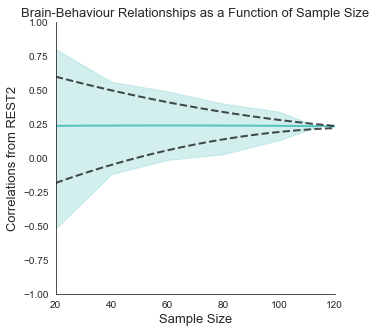

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

plt.xlim(bootstrap_results_REST["SAMPLES"].min(), bootstrap_results_REST["SAMPLES"].max())
plt.xlim(20, 120)

plt.ylim(-1.0, 1.0)

for d, ls, c in zip(bootstrap_results_REST["METHOD"].unique(), ["", "", "-", "--", "--"], ["lightseagreen", "lightseagreen", "lightseagreen", "k", "k"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = bootstrap_results_REST.loc[bootstrap_results_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.7}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

plt.fill_between(bootstrap_results_REST["SAMPLES"].unique(), bootstrap_results_REST[bootstrap_results_REST["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 bootstrap_results_REST[bootstrap_results_REST["METHOD"] == "MAX"]["COEFFICIENTS"],
                 color='lightseagreen', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("Correlations from REST2", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()


Step 2: Compute the brain-behaviour relationships using the bootstrapped timeseries of the developmental sample

In [11]:
#input directory of the head motion parameter (rmsFD) files in Session 1 & Session 2
rs_motion_param_datapath = '/Users/jivesh/Downloads/motion_params_FD004/*_task-rest_run-1_bold_mcf.nii.gz_rel.rms'
mv_motion_param_datapath = '/Users/jivesh/Downloads/motion_params_FD004/*_task-rest_run-2_bold_mcf.nii.gz_rel.rms'

rsfilename_motion_param_list = np.sort(glob.glob(rs_motion_param_datapath))
mvfilename_motion_param_list = np.sort(glob.glob(mv_motion_param_datapath))

#select a head motion threshold to identify contaminatedd timepoints in the timeseries
threshold = 0.40

#select a minimum amount of timepoints to be retained after identifying contaminated timepoints
mintimepoint = 20

#select the number of bootstrapped timepoints from the best timepoints for Session 1 & Session 2
#timepoints = 20

rssubj_exclusion = []
mvsubj_exclusion = []
all_unique_contaminated_indices = []

best_timepoints_size_s1 = []
best_timepoints_size_s2 = []


In [12]:
for rsfilename in range(rsfMRI_nonzero_timeseries.shape[0]):

    #load each subject's head motion parameter files for Session 1
    rmsFDs1 = np.loadtxt(rsfilename_motion_param_list[rsfilename])
    #find the indices of the contaminated timepoints with rmsFD > threshold
    rmsFDs1_thresh = np.asarray(np.where(rmsFDs1 > threshold))

    #find the indices of the preceding timepoints to be srubbed from the timeseries
    left_indices = rmsFDs1_thresh - 1
    #remove the indices less than 0 as indices should always start from zero
    left_nonzero_indices = left_indices[left_indices >= 0]
    #find the indices of the first succeeding timepoints to be scrubbed from the timeseries
    right_first_indices = rmsFDs1_thresh + 1
    #remove the indices of the first succeeding timepoints if they exceed the size of the timepoints
    right_first_in_range_indices = right_first_indices[right_first_indices < rmsFDs1.shape]
    #find the indices of the second succeeding timepoints to be scrubbed from the timeseries
    right_second_indices = rmsFDs1_thresh + 2
    #remove the indices of the second succeeding timepoints if they exceed the size of the timepoints
    right_second_in_range_indices = right_second_indices[right_second_indices < rmsFDs1.shape]

    #concatenate all the contaminated indices including the scrubbed indices into an array
    all_contaminated_indices = np.concatenate((rmsFDs1_thresh, left_nonzero_indices, right_first_in_range_indices, right_second_in_range_indices), axis = None)
    #find all the unique contaminated indices including the scrubbed indices
    unique_contaminated_indices = np.unique(all_contaminated_indices).astype(int)
    #append all subjects' unique contaminated indices including the scrubbed indices into an array
    all_unique_contaminated_indices.append(unique_contaminated_indices)

    #find the remaining amount of timepoints left after identifying the contaminated timepoints
    best_timepoints_size = rsfMRI_nonzero_timeseries.shape[2] - np.asarray(unique_contaminated_indices.shape)
    #store all subjects' remaining amount of timepoints left in an array
    best_timepoints_size_s1.append(best_timepoints_size)

    #identify the subjects who has less remaining amount of timepoints than the minimum amount of timepoints required
    if (best_timepoints_size < mintimepoint):
        rssubj_exclusion.append(rsfilename)

print(np.array(rssubj_exclusion).shape[0])


0


In [13]:
for mvfilename in range(mvfMRI_nonzero_timeseries.shape[0]):

    #load each subject's head motion parameter files for Session 2
    rmsFDs2 = np.loadtxt(mvfilename_motion_param_list[mvfilename])
    #find the indices of the contaminated timepoints with rmsFD > threshold
    rmsFDs2_thresh = np.asarray(np.where(rmsFDs2 > threshold))

    #find the indices of the preceding timepoints to be srubbed from the timeseries
    mvleft_indices = rmsFDs2_thresh - 1
    #remove the indices less than 0 as indices should always start from zero
    mvleft_nonzero_indices = mvleft_indices[mvleft_indices >= 0]
    #find the indices of the first succeeding timepoints to be scrubbed from the timeseries
    mvright_first_indices = rmsFDs2_thresh + 1
    #remove the indices of the first succeeding timepoints if they exceed the size of the timepoints
    mvright_first_in_range_indices = mvright_first_indices[mvright_first_indices < rmsFDs2.shape]
    #find the indices of the second succeeding timepoints to be scrubbed from the timeseries
    mvright_second_indices = rmsFDs2_thresh + 2
    #remove the indices of the second succeeding timepoints if they exceed the size of the timepoints
    mvright_second_in_range_indices = mvright_second_indices[mvright_second_indices < rmsFDs2.shape]

    #concatenate all the contaminated indices including the scrubbed indices into an array
    mvall_contaminated_indices = np.concatenate((rmsFDs2_thresh, mvleft_nonzero_indices, mvright_first_in_range_indices, mvright_second_in_range_indices), axis = None)
    #find all the unique contaminated indices including the scrubbed indices
    mvunique_contaminated_indices = np.unique(mvall_contaminated_indices).astype(int)
    #append all subjects' unique contaminated indices including the scrubbed indices into an array
    mvall_unique_contaminated_indices.append(mvunique_contaminated_indices)

    #find the remaining amount of timepoints left after identifying the contaminated timepoints
    best_mvtimepoints_size = mvfMRI_nonzero_timeseries.shape[2] - np.asarray(mvunique_contaminated_indices.shape)
    #store all subjects' remaining amount of timepoints left in an array
    best_timepoints_size_s2.append(best_mvtimepoints_size)

    #identify the subjects who has less remaining amount of timepoints than the minimum amount of timepoints required
    if (best_mvtimepoints_size < mintimepoint):
        mvsubj_exclusion.append(mvfilename)

print(np.array(mvsubj_exclusion).shape[0])


0


In [14]:
#concatenate all subjects to be excluded from Session 1 & Session 2
all_subj_exclusion = np.concatenate((rssubj_exclusion, mvsubj_exclusion), axis = None)
#find the unique subjects to be excluded from Session 1 & Session 2
unique_subj_exclusion = np.unique(all_subj_exclusion).astype(int)

#remove the size of the best timepoints for the subjects to be excluded for Session 1 & Session 2
best_timepoints_s1 = np.delete(best_timepoints_size_s1, unique_subj_exclusion)
best_timepoints_s2 = np.delete(best_timepoints_size_s2, unique_subj_exclusion)
print(best_timepoints_s1.shape[0]); print(best_timepoints_s2.shape[0])

#remove the subjects to be excluded from the original 3D array for Session 1 & Session 2
rsfMRI_nonzero_best_timeseries = np.delete(rsfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)
mvfMRI_nonzero_best_timeseries = np.delete(mvfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)
print(rsfMRI_nonzero_best_timeseries.shape); print(mvfMRI_nonzero_best_timeseries.shape)

#remove all the unique contaminated indices of the subjects to be excluded for Session 1 & Session 2
rsbest_unique_contaminated_indices = np.delete(all_unique_contaminated_indices, unique_subj_exclusion)
mvbest_unique_contaminated_indices = np.delete(mvall_unique_contaminated_indices, unique_subj_exclusion)
print(rsbest_unique_contaminated_indices.shape[0]); print(mvbest_unique_contaminated_indices.shape[0])


114
114
(114, 211, 375)
(114, 211, 375)
114
114


/Users/jivesh/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [16]:
rsfMRI_bestroi_nonzero_best_timeseries = np.take(rsfMRI_nonzero_best_timeseries, ROI_dimx, axis = 1).squeeze()
mvfMRI_bestroi_nonzero_best_timeseries = np.take(mvfMRI_nonzero_best_timeseries, ROI_dimx, axis = 1).squeeze()


In [17]:
#fingerprint accuracy with varying timepoints over minTP

timepoints = 500

#initialise an empty 3D array to store all subjects bootstrapped timepoints for Sessions 1 & 2 for each iteration
ROI = ((rsfMRI_nonzero_best_timeseries.shape[1] * rsfMRI_nonzero_best_timeseries.shape[1]) - rsfMRI_nonzero_best_timeseries.shape[1]) // 2
rsfMRI_bootstrapped_timepoints = np.zeros((500, rsfMRI_nonzero_best_timeseries.shape[0], ROI))
mvfMRI_bootstrapped_timepoints = np.zeros((500, mvfMRI_nonzero_best_timeseries.shape[0], ROI))

#initialise an empty 2D array to store the bootstrapped sample for all ROIs and their best timepoints for Session 1 & Session 2
bootstrap_all_roi_timeseries_s1 = np.zeros((rsfMRI_nonzero_best_timeseries.shape[1], timepoints))
bootstrap_all_roi_timeseries_s2 = np.zeros((mvfMRI_nonzero_best_timeseries.shape[1], timepoints))

for rs_epoch in range(0, 500):

    print(rs_epoch)
    for subs1 in range(rsfMRI_nonzero_best_timeseries.shape[0]):

        #initialise a 2D array to store each subject's best ROI timepoints for Session 1
        rsfMRI_timeseries_2d = np.zeros((rsfMRI_nonzero_best_timeseries.shape[1], best_timepoints_s1[subs1]))

        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 1
        remaining_motion_param_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)
        sub_rmsFD = remaining_motion_param_list[subs1]
        read_sub_rmsFD = np.loadtxt(sub_rmsFD)
        remaining_best_motion = np.delete(read_sub_rmsFD, rsbest_unique_contaminated_indices[subs1])
        find_indices_best_motion = np.argsort(remaining_best_motion)[:mintimepoint]
        #find_indices_best_motion = np.argsort(remaining_best_motion)

        for roi in range(rsfMRI_nonzero_best_timeseries.shape[1]):

            #copy the subject-wise timepoints for each ROI for Session 1
            rstimepoints = rsfMRI_nonzero_best_timeseries[subs1, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            best_scrubbed_timepoints = np.delete(rstimepoints, rsbest_unique_contaminated_indices[subs1])
            #store the best timepoints for each ROI into a 2D array for Session 1
            rsfMRI_timeseries_2d[roi, :] = best_scrubbed_timepoints[:]

        #find bootstrapped timepoints with replacement for Session 1
        bootstrap_sample = np.random.choice(find_indices_best_motion.shape[0], timepoints)

        for roi in range(bootstrap_all_roi_timeseries_s1.shape[0]):

            #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 1
            extract_bootstrap_timepoint = np.take(rsfMRI_timeseries_2d[roi, :], bootstrap_sample)
            #update the bootstrapped sample with each ROI's timepoints for Session 1
            bootstrap_all_roi_timeseries_s1[roi, :] = extract_bootstrap_timepoint[:]

        #compute the bootstrapped Pearson's correlation coefficient for Session 1
        rsfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s1)

        #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 1
        rsfMRI_corr_shen = rsfMRI_corr_matrix.shape[0]
        arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
        trunc_rsfMRI_corr_shen = rsfMRI_corr_matrix[arange_rsfMRI_corr, diag]

        #append the bootstrapped truncated correlation matrix of all subjects across all iterations for Session 1
        rsfMRI_bootstrapped_timepoints[rs_epoch, subs1, :] = trunc_rsfMRI_corr_shen[:]

#compute the bootstrapped correlation matrix averaged across all iterations for Session 1
average_rsfMRI_corr_matrix = np.mean(rsfMRI_bootstrapped_timepoints, axis = 0)
#transpose the average bootstrapped truncated correlation matrix of all subjects to ease further computation for Session 1
trans_average_rsfMRI_corr_matrix = np.transpose(average_rsfMRI_corr_matrix)

for mv_epoch in range(0, 500):

    print(mv_epoch)
    for subs2 in range(mvfMRI_nonzero_best_timeseries.shape[0]):

        #initialise a 2D array to store each subject's best ROI timepoints for Session 2
        mvfMRI_timeseries_2d = np.zeros((mvfMRI_nonzero_best_timeseries.shape[1], best_timepoints_s2[subs2]))

        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 2
        mvremaining_motion_param_list = np.delete(np.array(mvfilename_motion_param_list), unique_subj_exclusion)
        mvsub_rmsFD = mvremaining_motion_param_list[subs2]
        mvread_sub_rmsFD = np.loadtxt(mvsub_rmsFD)
        mvremaining_best_motion = np.delete(mvread_sub_rmsFD, mvbest_unique_contaminated_indices[subs2])
        #mvfind_indices_best_motion = np.argsort(mvremaining_best_motion)[:mintimepoint]
        mvfind_indices_best_motion = np.argsort(mvremaining_best_motion)

        for roi in range(mvfMRI_nonzero_best_timeseries.shape[1]):

            #copy the subject-wise timepoints for each ROI for Session 2
            mvtimepoints = mvfMRI_nonzero_best_timeseries[subs2, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            mvbest_scrubbed_timepoints = np.delete(mvtimepoints, mvbest_unique_contaminated_indices[subs2])
            #store the best timepoints for each ROI into a 2D array for Session 2
            mvfMRI_timeseries_2d[roi, :] = mvbest_scrubbed_timepoints[:]

        #find bootstrapped timepoints with replacement from the first ROI for Session 2
        mvbootstrap_sample = np.random.choice(mvfind_indices_best_motion.shape[0], timepoints)

        for roi in range(bootstrap_all_roi_timeseries_s2.shape[0]):

            #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 2
            extract_mvbootstrap_timepoint = np.take(mvfMRI_timeseries_2d[roi, :], mvbootstrap_sample)
            #update the bootstrapped sample with each ROI's timepoints for Session 2
            bootstrap_all_roi_timeseries_s2[roi, :] = extract_mvbootstrap_timepoint[:]

        #compute the bootstrapped Pearson's correlation coefficient for Session 2
        mvfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s2)

        #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 2
        mvfMRI_corr_shen = mvfMRI_corr_matrix.shape[0]
        arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
        trunc_mvfMRI_corr_shen = mvfMRI_corr_matrix[arange_mvfMRI_corr, diag]

        #append the bootstrapped truncated correlation matrix of all subjects across all iterations for Session 2
        mvfMRI_bootstrapped_timepoints[mv_epoch, subs2, :] = trunc_mvfMRI_corr_shen[:]

#compute the bootstrapped correlation matrix averaged across all iterations for Session 2
average_mvfMRI_corr_matrix = np.mean(mvfMRI_bootstrapped_timepoints, axis = 0)
#transpose the average bootstrapped truncated correlation matrix of all subjects to ease further computation for Session 2
trans_average_mvfMRI_corr_matrix = np.transpose(average_mvfMRI_corr_matrix)

#compute columnwise pearson's correlation coeffcient between Session 1 & Session 2 to produce subject-wise correlation matrix (N x N)
trans_rsfMRI_corr = (trans_average_rsfMRI_corr_matrix - trans_average_rsfMRI_corr_matrix.mean(axis = 0)) / trans_average_rsfMRI_corr_matrix.std(axis = 0)
trans_mvfMRI_corr = (trans_average_mvfMRI_corr_matrix - trans_average_mvfMRI_corr_matrix.mean(axis = 0)) / trans_average_mvfMRI_corr_matrix.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

#compute binary identification using the subject-wise correlation matrix between sessions
#extract the diagonal values of the correlation matrix
diag_corr_matrix = np.diag(rs_mv_corr)

#find the maximum value in each column of the correlation matrix
max_corr = np.amax(rs_mv_corr, axis = 1)

#ID is based on a binary system where each diagonal value is compared with the
#maximum value of that column in the correlation matrix. We expect that the
#diagnoal value is greater than or equal to the maximum value to allow successful identification
BID = np.greater_equal(diag_corr_matrix, max_corr)
print(BID)

#success rate is defined as the total number of positive identifications divided
#by the total number of subjects
ID_accuracy = np.sum(BID) / (BID.shape)
print(ID_accuracy)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
#fingerprint accuracy with similar number of timepoints above minTP

timepoints = 500

#initialise an empty 3D array to store all subjects bootstrapped timepoints for Sessions 1 & 2 for each iteration
ROI = ((rsfMRI_nonzero_best_timeseries.shape[1] * rsfMRI_nonzero_best_timeseries.shape[1]) - rsfMRI_nonzero_best_timeseries.shape[1]) // 2
rsfMRI_bootstrapped_timepoints = np.zeros((500, rsfMRI_nonzero_best_timeseries.shape[0], ROI))
mvfMRI_bootstrapped_timepoints = np.zeros((500, mvfMRI_nonzero_best_timeseries.shape[0], ROI))

#initialise an empty 2D array to store the bootstrapped sample for all ROIs and their best timepoints for Session 1 & Session 2
bootstrap_all_roi_timeseries_s1 = np.zeros((rsfMRI_nonzero_best_timeseries.shape[1], timepoints))
bootstrap_all_roi_timeseries_s2 = np.zeros((mvfMRI_nonzero_best_timeseries.shape[1], timepoints))

for rs_epoch in range(0, 500):

    print(rs_epoch)
    
    min_best_timepoints_s1 = best_timepoints_s1.min()
    
    for subs1 in range(rsfMRI_nonzero_best_timeseries.shape[0]):

        #initialise a 2D array to store each subject's best ROI timepoints for Session 1
        rsfMRI_timeseries_2d = np.zeros((rsfMRI_nonzero_best_timeseries.shape[1], best_timepoints_s1[subs1]))

        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 1
        remaining_motion_param_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)
        sub_rmsFD = remaining_motion_param_list[subs1]
        read_sub_rmsFD = np.loadtxt(sub_rmsFD)
        remaining_best_motion = np.delete(read_sub_rmsFD, rsbest_unique_contaminated_indices[subs1])
        #find_indices_best_motion = np.argsort(remaining_best_motion)[:mintimepoint]
        find_indices_best_motion = np.argsort(remaining_best_motion)[:min_best_timepoints_s1]

        for roi in range(rsfMRI_nonzero_best_timeseries.shape[1]):

            #copy the subject-wise timepoints for each ROI for Session 1
            rstimepoints = rsfMRI_nonzero_best_timeseries[subs1, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            best_scrubbed_timepoints = np.delete(rstimepoints, rsbest_unique_contaminated_indices[subs1])
            #store the best timepoints for each ROI into a 2D array for Session 1
            rsfMRI_timeseries_2d[roi, :] = best_scrubbed_timepoints[:]

        #find bootstrapped timepoints with replacement for Session 1
        bootstrap_sample = np.random.choice(find_indices_best_motion.shape[0], timepoints)

        for roi in range(bootstrap_all_roi_timeseries_s1.shape[0]):

            #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 1
            extract_bootstrap_timepoint = np.take(rsfMRI_timeseries_2d[roi, :], bootstrap_sample)
            #update the bootstrapped sample with each ROI's timepoints for Session 1
            bootstrap_all_roi_timeseries_s1[roi, :] = extract_bootstrap_timepoint[:]

        #compute the bootstrapped Pearson's correlation coefficient for Session 1
        rsfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s1)

        #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 1
        rsfMRI_corr_shen = rsfMRI_corr_matrix.shape[0]
        arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
        trunc_rsfMRI_corr_shen = rsfMRI_corr_matrix[arange_rsfMRI_corr, diag]

        #append the bootstrapped truncated correlation matrix of all subjects across all iterations for Session 1
        rsfMRI_bootstrapped_timepoints[rs_epoch, subs1, :] = trunc_rsfMRI_corr_shen[:]

#compute the bootstrapped correlation matrix averaged across all iterations for Session 1
average_rsfMRI_corr_matrix = np.mean(rsfMRI_bootstrapped_timepoints, axis = 0)
#transpose the average bootstrapped truncated correlation matrix of all subjects to ease further computation for Session 1
trans_average_rsfMRI_corr_matrix = np.transpose(average_rsfMRI_corr_matrix)

for mv_epoch in range(0, 500):

    print(mv_epoch)
    
    min_best_timepoints_s2 = best_timepoints_s2.min()
    
    for subs2 in range(mvfMRI_nonzero_best_timeseries.shape[0]):

        #initialise a 2D array to store each subject's best ROI timepoints for Session 2
        mvfMRI_timeseries_2d = np.zeros((mvfMRI_nonzero_best_timeseries.shape[1], best_timepoints_s2[subs2]))

        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 2
        mvremaining_motion_param_list = np.delete(np.array(mvfilename_motion_param_list), unique_subj_exclusion)
        mvsub_rmsFD = mvremaining_motion_param_list[subs2]
        mvread_sub_rmsFD = np.loadtxt(mvsub_rmsFD)
        mvremaining_best_motion = np.delete(mvread_sub_rmsFD, mvbest_unique_contaminated_indices[subs2])
        #mvfind_indices_best_motion = np.argsort(mvremaining_best_motion)[:mintimepoint]
        mvfind_indices_best_motion = np.argsort(mvremaining_best_motion)[:min_best_timepoints_s2]

        for roi in range(mvfMRI_nonzero_best_timeseries.shape[1]):

            #copy the subject-wise timepoints for each ROI for Session 2
            mvtimepoints = mvfMRI_nonzero_best_timeseries[subs2, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            mvbest_scrubbed_timepoints = np.delete(mvtimepoints, mvbest_unique_contaminated_indices[subs2])
            #store the best timepoints for each ROI into a 2D array for Session 2
            mvfMRI_timeseries_2d[roi, :] = mvbest_scrubbed_timepoints[:]

        #find bootstrapped timepoints with replacement from the first ROI for Session 2
        mvbootstrap_sample = np.random.choice(mvfind_indices_best_motion.shape[0], timepoints)

        for roi in range(bootstrap_all_roi_timeseries_s2.shape[0]):

            #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 2
            extract_mvbootstrap_timepoint = np.take(mvfMRI_timeseries_2d[roi, :], mvbootstrap_sample)
            #update the bootstrapped sample with each ROI's timepoints for Session 2
            bootstrap_all_roi_timeseries_s2[roi, :] = extract_mvbootstrap_timepoint[:]

        #compute the bootstrapped Pearson's correlation coefficient for Session 2
        mvfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s2)

        #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 2
        mvfMRI_corr_shen = mvfMRI_corr_matrix.shape[0]
        arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
        trunc_mvfMRI_corr_shen = mvfMRI_corr_matrix[arange_mvfMRI_corr, diag]

        #append the bootstrapped truncated correlation matrix of all subjects across all iterations for Session 2
        mvfMRI_bootstrapped_timepoints[mv_epoch, subs2, :] = trunc_mvfMRI_corr_shen[:]

#compute the bootstrapped correlation matrix averaged across all iterations for Session 2
average_mvfMRI_corr_matrix = np.mean(mvfMRI_bootstrapped_timepoints, axis = 0)
#transpose the average bootstrapped truncated correlation matrix of all subjects to ease further computation for Session 2
trans_average_mvfMRI_corr_matrix = np.transpose(average_mvfMRI_corr_matrix)

#compute columnwise pearson's correlation coeffcient between Session 1 & Session 2 to produce subject-wise correlation matrix (N x N)
trans_rsfMRI_corr = (trans_average_rsfMRI_corr_matrix - trans_average_rsfMRI_corr_matrix.mean(axis = 0)) / trans_average_rsfMRI_corr_matrix.std(axis = 0)
trans_mvfMRI_corr = (trans_average_mvfMRI_corr_matrix - trans_average_mvfMRI_corr_matrix.mean(axis = 0)) / trans_average_mvfMRI_corr_matrix.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

#compute binary identification using the subject-wise correlation matrix between sessions
#extract the diagonal values of the correlation matrix
diag_corr_matrix = np.diag(rs_mv_corr)

#find the maximum value in each column of the correlation matrix
max_corr = np.amax(rs_mv_corr, axis = 1)

#ID is based on a binary system where each diagonal value is compared with the
#maximum value of that column in the correlation matrix. We expect that the
#diagnoal value is greater than or equal to the maximum value to allow successful identification
BID = np.greater_equal(diag_corr_matrix, max_corr)
print(BID)

#success rate is defined as the total number of positive identifications divided
#by the total number of subjects
ID_accuracy = np.sum(BID) / (BID.shape)
print(ID_accuracy)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [17]:
#initialise an empty 3D array to store all subjects bootstrapped timepoints for Sessions 1 & 2 for each iteration
#ROI = ((rsfMRI_nonzero_best_timeseries.shape[1] * rsfMRI_nonzero_best_timeseries.shape[1]) - rsfMRI_nonzero_best_timeseries.shape[1]) // 2
#rsfMRI_bootstrapped_timepoints = np.zeros((rsfMRI_nonzero_best_timeseries.shape[0], ROI))
#mvfMRI_bootstrapped_timepoints = np.zeros((mvfMRI_nonzero_best_timeseries.shape[0], ROI))
rsfMRI_bootstrapped_timepoints = []
mvfMRI_bootstrapped_timepoints = []
#initialise an empty 2D array to store the bootstrapped sample for all ROIs and their best timepoints for Session 1 & Session 2
#bootstrap_all_roi_timeseries_s1 = np.zeros((rsfMRI_nonzero_best_timeseries.shape[1], timepoints))
#bootstrap_all_roi_timeseries_s2 = np.zeros((mvfMRI_nonzero_best_timeseries.shape[1], timepoints))


In [37]:
timepoints = 20

rsfMRI_bootstrapped_timepoints = []
bootstrap_all_roi_timeseries_s1 = np.zeros((rsfMRI_bestroi_nonzero_best_timeseries.shape[1], timepoints))
bootstrap_all_roi_timeseries_s2 = np.zeros((mvfMRI_bestroi_nonzero_best_timeseries.shape[1], timepoints))

for subs1 in range(rsfMRI_bestroi_nonzero_best_timeseries.shape[0]):
    
    #initialise a 2D array to store each subject's best ROI timepoints for Session 1
    rsfMRI_timeseries_2d = np.zeros((rsfMRI_bestroi_nonzero_best_timeseries.shape[1], best_timepoints_s1[subs1]))

    #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 1
    remaining_motion_param_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)
    sub_rmsFD = remaining_motion_param_list[subs1]
    read_sub_rmsFD = np.loadtxt(sub_rmsFD)
    remaining_best_motion = np.delete(read_sub_rmsFD, rsbest_unique_contaminated_indices[subs1])
    find_indices_best_motion = np.argsort(remaining_best_motion)[:mintimepoint]

    for roi in range(rsfMRI_bestroi_nonzero_best_timeseries.shape[1]):
        
        #copy the subject-wise timepoints for each ROI for Session 1
        rstimepoints = rsfMRI_bestroi_nonzero_best_timeseries[subs1, roi, :].copy()
        #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
        best_scrubbed_timepoints = np.delete(rstimepoints, rsbest_unique_contaminated_indices[subs1])
        #store the best timepoints for each ROI into a 2D array for Session 1
        rsfMRI_timeseries_2d[roi, :] = best_scrubbed_timepoints[:]
    
    bootstrap_sample = np.random.choice(find_indices_best_motion, timepoints)
    
    for roi in range(bootstrap_all_roi_timeseries_s1.shape[0]):
        
        extract_bootstrap_timepoint = np.take(rsfMRI_timeseries_2d[roi, :], bootstrap_sample)
        bootstrap_all_roi_timeseries_s1[roi, :] = extract_bootstrap_timepoint[:]
    
    #compute the bootstrapped Pearson's correlation coefficient for Session 1
    rsfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s1)
    
    #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 1
    rsfMRI_corr_shen = rsfMRI_corr_matrix.shape[0]
    arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
    trunc_rsfMRI_corr_shen = rsfMRI_corr_matrix[arange_rsfMRI_corr, diag]

    #append append the truncated correlation matrix of all subjects to the list for Session 1
    rsfMRI_bootstrapped_timepoints.append(trunc_rsfMRI_corr_shen)

    #convert the list to an array for Session 1
rsfMRI_bootstrapped_timepoints_to_array = np.asarray(rsfMRI_bootstrapped_timepoints)

print(rsfMRI_bootstrapped_timepoints_to_array.shape)


(114, 22155)


In [38]:
behav3 = behav_df[['AGE', 'SEX', 'REST1_FD']]
behav3 = pd.DataFrame(np.delete(np.array(behav3), unique_subj_exclusion, axis = 0))
behav3.columns = ['AGE', 'SEX', 'REST1_FD']
behav3


,AGE,SEX,REST1_FD
0,12.84,0.0,0.0977
1,11.34,1.0,0.1379
2,15.19,0.0,0.1220
3,9.75,0.0,0.0654
4,16.55,0.0,0.1123
...,...,...,...
109,12.18,0.0,0.1445
110,16.53,1.0,0.0835
111,6.98,1.0,0.1072
112,9.59,1.0,0.0597


In [39]:
import pingouin as pg

model3_pval = []
model3_coef = []

for edge in range(0, rsfMRI_bootstrapped_timepoints_to_array.shape[1]):
    
    behav3['FC'] = rsfMRI_bootstrapped_timepoints_to_array[:, edge]
    model3 = pg.partial_corr(data = behav3, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model3_pval.append(model3['p-val'])
    model3_coef.append(model3['r'])
    

In [40]:
import statsmodels.stats.multitest as mc
corr_pval = mc.multipletests(np.array(model3_pval).flatten(), alpha = 0.05, method = 'fdr_bh')
corr_pval


(array([False, False, False, ..., False, False, False]),
 array([0.94048282, 0.97919442, 0.94129755, ..., 0.96044213, 0.86219135,
        0.97919442]),
 2.315199052582706e-06,
 2.2568269013766643e-06)

In [41]:
pcorr_indices = np.where(corr_pval[1] <= 0.05)
np.array(pcorr_indices).shape[1]


0

In [17]:
REST1_coef3 = np.array(np.take(model3_coef, pcorr_indices)).flatten()
REST1_pval3 = np.array(np.take(model3_pval, pcorr_indices)).flatten()
max_corr_edge = REST1_coef3.argmax()
max_corr_edge

best_edge = np.array(np.where(model3_coef == REST1_coef3[max_corr_edge])).squeeze()[0]
best_edge


ValueError: attempt to get argmax of an empty sequence

In [16]:
numROI = rsfMRI_nonzero_best_timeseries.shape[1]

A = np.arange(numROI * numROI).reshape(numROI, numROI)
A2 = np.arange(numROI * numROI).reshape(numROI, numROI)
np.fill_diagonal(A, 1)

B = A[np.triu_indices(numROI, k = 1)]
ROI_dimx = np.where(A2 == B[best_edge])
rsfMRI_bestroi_nonzero_best_timeseries = np.take(rsfMRI_nonzero_best_timeseries, ROI_dimx, axis = 1).squeeze()
mvfMRI_bestroi_nonzero_best_timeseries = np.take(mvfMRI_nonzero_best_timeseries, ROI_dimx, axis = 1).squeeze()

print(A)
print(rsfMRI_bestroi_nonzero_best_timeseries.shape)
print(mvfMRI_bestroi_nonzero_best_timeseries.shape)


[[    1     1     2 ...   208   209   210]
 [  211     1   213 ...   419   420   421]
 [  422   423     1 ...   630   631   632]
 ...
 [43888 43889 43890 ...     1 44097 44098]
 [44099 44100 44101 ... 44307     1 44309]
 [44310 44311 44312 ... 44518 44519     1]]
(81, 2, 375)
(81, 2, 375)


In [16]:
for subs2 in range(mvfMRI_nonzero_best_timeseries.shape[0]):
    
    #initialise a 2D array to store each subject's best ROI timepoints for Session 2
    mvfMRI_timeseries_2d = np.zeros((mvfMRI_nonzero_best_timeseries.shape[1], best_timepoints_s2[subs2]))

    #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 2
    mvremaining_motion_param_list = np.delete(np.array(mvfilename_motion_param_list), unique_subj_exclusion)
    mvsub_rmsFD = mvremaining_motion_param_list[subs2]
    mvread_sub_rmsFD = np.loadtxt(mvsub_rmsFD)
    mvremaining_best_motion = np.delete(mvread_sub_rmsFD, mvbest_unique_contaminated_indices[subs2])
    mvfind_indices_best_motion = np.argsort(mvremaining_best_motion)[:mintimepoint]

    for roi in range(mvfMRI_nonzero_best_timeseries.shape[1]):
        
        #copy the subject-wise timepoints for each ROI for Session 2
        mvtimepoints = mvfMRI_nonzero_best_timeseries[subs2, roi, :].copy()
        #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
        mvbest_scrubbed_timepoints = np.delete(mvtimepoints, mvbest_unique_contaminated_indices[subs2])
        #store the best timepoints for each ROI into a 2D array for Session 2
        mvfMRI_timeseries_2d[roi, :] = mvbest_scrubbed_timepoints[:]
        
    #compute the bootstrapped Pearson's correlation coefficient for Session 2
    mvfMRI_corr_matrix = np.corrcoef(mvfMRI_timeseries_2d)

    #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 2
    mvfMRI_corr_shen = mvfMRI_corr_matrix.shape[0]
    arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
    trunc_mvfMRI_corr_shen = mvfMRI_corr_matrix[arange_mvfMRI_corr, diag]

    #append append the truncated correlation matrix of all subjects to the list for Session 2
    mvfMRI_bootstrapped_timepoints.append(trunc_mvfMRI_corr_shen)
    
#convert the list to an array for Session 1
mvfMRI_bootstrapped_timepoints_to_array = np.asarray(mvfMRI_bootstrapped_timepoints)

print(mvfMRI_bootstrapped_timepoints_to_array.shape)


(113, 22155)


In [18]:
model4_pval = []
model4_coef = []

behav4 = behav_df[['AGE', 'SEX', 'REST2_FD']]
behav4 = pd.DataFrame(np.delete(np.array(behav4), unique_subj_exclusion, axis = 0))
behav4.columns = ['AGE', 'SEX', 'REST2_FD']

REST2_edges = np.take(mvfMRI_bootstrapped_timepoints_to_array, pcorr_indices, axis = 1).squeeze()

for edge in range(REST2_edges.shape[1]):
    
    behav4['FC'] = REST2_edges[:, edge]
    model4 = pg.partial_corr(data = behav4, x = 'AGE', y = 'FC', covar = ['SEX', 'REST2_FD'], method = 'spearman')
    model4_pval.append(model4['p-val'])
    model4_coef.append(model4['r'])
    

In [16]:
REST1_coef = np.array(np.take(model3_coef, pcorr_indices)).flatten()
REST2_coef = np.array(model4_coef).flatten()

pg.corr(x = REST1_coef, y = REST2_coef, method = "spearman")


,n,r,CI95%,r2,adj_r2,p-val,power
spearman,43,0.620984,"[0.39, 0.78]",0.385621,0.354902,0.000009,0.996309


In [47]:
subjects = 114
epochs = 500
epochs_tp = 500

timepoints = 20

all_rssamples = []
all_mvsamples = []
edges = ((rsfMRI_bestroi_nonzero_best_timeseries.shape[1] * rsfMRI_bestroi_nonzero_best_timeseries.shape[1]) - rsfMRI_bestroi_nonzero_best_timeseries.shape[1]) // 2

rsbootstrap_rsfMRI_corr = np.zeros((epochs, edges))
mvbootstrap_rsfMRI_corr = np.zeros((epochs, edges))

rsbootstrap_corr = np.zeros((epochs, subjects))
mvbootstrap_corr = np.zeros((epochs, subjects))

for epoch in range(epochs):
    
    print(epoch)
    samples = np.random.choice(rsfMRI_bestroi_nonzero_best_timeseries.shape[0], subjects, replace = False)
    rsbootstrap_samples = np.take(rsfMRI_bestroi_nonzero_best_timeseries, samples, axis = 0)
    all_rssamples.append(samples)
    
    bootstrap_best_timepoints_s1 = np.take(np.array(best_timepoints_s1), samples)
    bootstrap_rsbest_unique_contaminated_indices = np.take(np.array(rsbest_unique_contaminated_indices), samples)
        
    for subs1 in range(rsbootstrap_samples.shape[0]):
        
        #initialise a 2D array to store each subject's best ROI timepoints for Session 1
        rsfMRI_timeseries_2d = np.zeros((rsfMRI_bestroi_nonzero_best_timeseries.shape[1], bootstrap_best_timepoints_s1[subs1]))
       
        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 1
        remaining_motion_param_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)
        sub_rmsFD = remaining_motion_param_list[subs1]
        read_sub_rmsFD = np.loadtxt(sub_rmsFD)
        remaining_best_motion = np.delete(read_sub_rmsFD, bootstrap_rsbest_unique_contaminated_indices[subs1])
        find_indices_best_motion = np.argsort(remaining_best_motion)[:mintimepoint]
      
        bootstrap_all_roi_timeseries_s1 = np.zeros((rsfMRI_timeseries_2d.shape[0], timepoints))
        
        for roi in range(rsbootstrap_samples.shape[1]):
        
            #copy the subject-wise timepoints for each ROI for Session 1
            rstimepoints = rsbootstrap_samples[subs1, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            best_scrubbed_timepoints = np.delete(rstimepoints, bootstrap_rsbest_unique_contaminated_indices[subs1])
            
            #store the best timepoints for each ROI into a 2D array for Session 1
            rsfMRI_timeseries_2d[roi, :] = best_scrubbed_timepoints[:]
        
        rsfMRI_trunc_timeseries_2d = np.take(rsfMRI_timeseries_2d, find_indices_best_motion, axis = 1)
        
        for epoch2 in range(epochs_tp):
            
            #find bootstrapped timepoints with replacement for Session 1
            #bootstrap_sample = np.random.choice(find_indices_best_motion, timepoints, replace = True)
            bootstrap_sample = np.random.choice(rsfMRI_trunc_timeseries_2d.shape[1], timepoints, replace = True)
            
            for roi in range(rsfMRI_timeseries_2d.shape[0]):

                #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 1
                extract_bootstrap_timepoint = np.take(rsfMRI_trunc_timeseries_2d[roi, :], bootstrap_sample)
                #update the bootstrapped sample with each ROI's timepoints for Session 1
                bootstrap_all_roi_timeseries_s1[roi, :] = extract_bootstrap_timepoint[:]
        
            #compute the bootstrapped Pearson's correlation coefficient for Session 1
            rsfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s1)
            
            #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 1
            rsfMRI_corr_shen = rsfMRI_corr_matrix.shape[0]
            arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
            trunc_rsfMRI_corr_shen = rsfMRI_corr_matrix[arange_rsfMRI_corr, diag]
            
            #append append the truncated correlation matrix of all subjects for all epochs to the list for Session 1
            rsbootstrap_rsfMRI_corr[epoch2] = trunc_rsfMRI_corr_shen
        
        mean_rsbootstrap_rsfMRI_corr = np.mean(rsbootstrap_rsfMRI_corr)
        rsbootstrap_corr[epoch, subs1] = mean_rsbootstrap_rsfMRI_corr
        
print(rsbootstrap_corr.shape)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [71]:
#fingerprint accuracy with varying timepoints over minTP
mintimepoint = 20
timepoints = 300

#initialise an empty 3D array to store all subjects bootstrapped timepoints for Sessions 1 & 2 for each iteration
ROI = ((rsfMRI_nonzero_best_timeseries.shape[1] * rsfMRI_nonzero_best_timeseries.shape[1]) - rsfMRI_nonzero_best_timeseries.shape[1]) // 2
rsfMRI_bootstrapped_timepoints = np.zeros((500, rsfMRI_nonzero_best_timeseries.shape[0], ROI))
mvfMRI_bootstrapped_timepoints = np.zeros((500, mvfMRI_nonzero_best_timeseries.shape[0], ROI))

#initialise an empty 2D array to store the bootstrapped sample for all ROIs and their best timepoints for Session 1 & Session 2
bootstrap_all_roi_timeseries_s1 = np.zeros((rsfMRI_nonzero_best_timeseries.shape[1], timepoints))
bootstrap_all_roi_timeseries_s2 = np.zeros((mvfMRI_nonzero_best_timeseries.shape[1], timepoints))

for rs_epoch in range(0, 500):

    print(rs_epoch)
    for subs1 in range(rsfMRI_nonzero_best_timeseries.shape[0]):

        #initialise a 2D array to store each subject's best ROI timepoints for Session 1
        rsfMRI_timeseries_2d = np.zeros((rsfMRI_nonzero_best_timeseries.shape[1], best_timepoints_s1[subs1]))

        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 1
        remaining_motion_param_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)
        sub_rmsFD = remaining_motion_param_list[subs1]
        read_sub_rmsFD = np.loadtxt(sub_rmsFD)
        remaining_best_motion = np.delete(read_sub_rmsFD, rsbest_unique_contaminated_indices[subs1])
        find_indices_best_motion = np.argsort(remaining_best_motion)[:mintimepoint]
        #find_indices_best_motion = np.argsort(remaining_best_motion)

        for roi in range(rsfMRI_nonzero_best_timeseries.shape[1]):

            #copy the subject-wise timepoints for each ROI for Session 1
            rstimepoints = rsfMRI_nonzero_best_timeseries[subs1, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            best_scrubbed_timepoints = np.delete(rstimepoints, rsbest_unique_contaminated_indices[subs1])
            #store the best timepoints for each ROI into a 2D array for Session 1
            rsfMRI_timeseries_2d[roi, :] = best_scrubbed_timepoints[:]
        
        rsfMRI_trunc_timeseries_2d = np.take(rsfMRI_timeseries_2d, find_indices_best_motion, axis = 1)

        #find bootstrapped timepoints with replacement for Session 1
        bootstrap_sample = np.random.choice(rsfMRI_trunc_timeseries_2d.shape[1], timepoints)

        for roi in range(bootstrap_all_roi_timeseries_s1.shape[0]):

            #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 1
            extract_bootstrap_timepoint = np.take(rsfMRI_timeseries_2d[roi, :], bootstrap_sample)
            #update the bootstrapped sample with each ROI's timepoints for Session 1
            bootstrap_all_roi_timeseries_s1[roi, :] = extract_bootstrap_timepoint[:]

        #compute the bootstrapped Pearson's correlation coefficient for Session 1
        rsfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s1)

        #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 1
        rsfMRI_corr_shen = rsfMRI_corr_matrix.shape[0]
        arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
        trunc_rsfMRI_corr_shen = rsfMRI_corr_matrix[arange_rsfMRI_corr, diag]

        #append the bootstrapped truncated correlation matrix of all subjects across all iterations for Session 1
        rsfMRI_bootstrapped_timepoints[rs_epoch, subs1, :] = trunc_rsfMRI_corr_shen[:]

#compute the bootstrapped correlation matrix averaged across all iterations for Session 1
average_rsfMRI_corr_matrix = np.mean(rsfMRI_bootstrapped_timepoints, axis = 0)
#transpose the average bootstrapped truncated correlation matrix of all subjects to ease further computation for Session 1
trans_average_rsfMRI_corr_matrix = np.transpose(average_rsfMRI_corr_matrix)

for mv_epoch in range(0, 500):

    print(mv_epoch)
    for subs2 in range(mvfMRI_nonzero_best_timeseries.shape[0]):

        #initialise a 2D array to store each subject's best ROI timepoints for Session 2
        mvfMRI_timeseries_2d = np.zeros((mvfMRI_nonzero_best_timeseries.shape[1], best_timepoints_s2[subs2]))

        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 2
        mvremaining_motion_param_list = np.delete(np.array(mvfilename_motion_param_list), unique_subj_exclusion)
        mvsub_rmsFD = mvremaining_motion_param_list[subs2]
        mvread_sub_rmsFD = np.loadtxt(mvsub_rmsFD)
        mvremaining_best_motion = np.delete(mvread_sub_rmsFD, mvbest_unique_contaminated_indices[subs2])
        #mvfind_indices_best_motion = np.argsort(mvremaining_best_motion)[:mintimepoint]
        mvfind_indices_best_motion = np.argsort(mvremaining_best_motion)[:mintimepoint]

        for roi in range(mvfMRI_nonzero_best_timeseries.shape[1]):

            #copy the subject-wise timepoints for each ROI for Session 2
            mvtimepoints = mvfMRI_nonzero_best_timeseries[subs2, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            mvbest_scrubbed_timepoints = np.delete(mvtimepoints, mvbest_unique_contaminated_indices[subs2])
            #store the best timepoints for each ROI into a 2D array for Session 2
            mvfMRI_timeseries_2d[roi, :] = mvbest_scrubbed_timepoints[:]
        
        mvfMRI_trunc_timeseries_2d = np.take(mvfMRI_timeseries_2d, mvfind_indices_best_motion, axis = 1)
        
        #find bootstrapped timepoints with replacement from the first ROI for Session 2
        mvbootstrap_sample = np.random.choice(mvfMRI_trunc_timeseries_2d.shape[1], timepoints)

        for roi in range(bootstrap_all_roi_timeseries_s2.shape[0]):

            #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 2
            extract_mvbootstrap_timepoint = np.take(mvfMRI_timeseries_2d[roi, :], mvbootstrap_sample)
            #update the bootstrapped sample with each ROI's timepoints for Session 2
            bootstrap_all_roi_timeseries_s2[roi, :] = extract_mvbootstrap_timepoint[:]

        #compute the bootstrapped Pearson's correlation coefficient for Session 2
        mvfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s2)

        #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 2
        mvfMRI_corr_shen = mvfMRI_corr_matrix.shape[0]
        arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
        trunc_mvfMRI_corr_shen = mvfMRI_corr_matrix[arange_mvfMRI_corr, diag]

        #append the bootstrapped truncated correlation matrix of all subjects across all iterations for Session 2
        mvfMRI_bootstrapped_timepoints[mv_epoch, subs2, :] = trunc_mvfMRI_corr_shen[:]

#compute the bootstrapped correlation matrix averaged across all iterations for Session 2
average_mvfMRI_corr_matrix = np.mean(mvfMRI_bootstrapped_timepoints, axis = 0)
#transpose the average bootstrapped truncated correlation matrix of all subjects to ease further computation for Session 2
trans_average_mvfMRI_corr_matrix = np.transpose(average_mvfMRI_corr_matrix)

#compute columnwise pearson's correlation coeffcient between Session 1 & Session 2 to produce subject-wise correlation matrix (N x N)
trans_rsfMRI_corr = (trans_average_rsfMRI_corr_matrix - trans_average_rsfMRI_corr_matrix.mean(axis = 0)) / trans_average_rsfMRI_corr_matrix.std(axis = 0)
trans_mvfMRI_corr = (trans_average_mvfMRI_corr_matrix - trans_average_mvfMRI_corr_matrix.mean(axis = 0)) / trans_average_mvfMRI_corr_matrix.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

#compute binary identification using the subject-wise correlation matrix between sessions
#extract the diagonal values of the correlation matrix
diag_corr_matrix = np.diag(rs_mv_corr)

#find the maximum value in each column of the correlation matrix
max_corr = np.amax(rs_mv_corr, axis = 1)

#ID is based on a binary system where each diagonal value is compared with the
#maximum value of that column in the correlation matrix. We expect that the
#diagnoal value is greater than or equal to the maximum value to allow successful identification
BID = np.greater_equal(diag_corr_matrix, max_corr)
print(BID)

#success rate is defined as the total number of positive identifications divided
#by the total number of subjects
ID_accuracy = np.sum(BID) / (BID.shape)
print(ID_accuracy)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [73]:
for epoch in range(epochs):
    
    print(epoch)
    samples = np.random.choice(mvfMRI_bestroi_nonzero_best_timeseries.shape[0], subjects, replace = False)
    mvbootstrap_samples = np.take(mvfMRI_bestroi_nonzero_best_timeseries, samples, axis = 0)
    all_mvsamples.append(samples)
    
    bootstrap_best_timepoints_s2 = np.take(np.array(best_timepoints_s2), samples)
    bootstrap_mvbest_unique_contaminated_indices = np.take(np.array(mvbest_unique_contaminated_indices), samples)
        
    for subs2 in range(mvbootstrap_samples.shape[0]):
        
        #initialise a 2D array to store each subject's best ROI timepoints for Session 1
        mvfMRI_timeseries_2d = np.zeros((mvfMRI_bestroi_nonzero_best_timeseries.shape[1], bootstrap_best_timepoints_s2[subs2]))
       
        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 1
        remaining_motion_param_list = np.delete(np.array(mvfilename_motion_param_list), unique_subj_exclusion)
        sub_rmsFD = remaining_motion_param_list[subs2]
        read_sub_rmsFD = np.loadtxt(sub_rmsFD)
        remaining_best_motion = np.delete(read_sub_rmsFD, mvbest_unique_contaminated_indices[subs2])
        find_indices_best_motion = np.argsort(remaining_best_motion)[:mintimepoint]
        
        bootstrap_all_roi_timeseries_s2 = np.zeros((mvfMRI_timeseries_2d.shape[0], mvfMRI_timeseries_2d.shape[1]))
        
        for roi in range(mvbootstrap_samples.shape[1]):
        
            #copy the subject-wise timepoints for each ROI for Session 1
            mvtimepoints = mvbootstrap_samples[subs2, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            best_scrubbed_timepoints = np.delete(mvtimepoints, bootstrap_mvbest_unique_contaminated_indices[subs2])
            
            #store the best timepoints for each ROI into a 2D array for Session 1
            mvfMRI_timeseries_2d[roi, :] = best_scrubbed_timepoints[:]
        
        for epoch2 in range(epochs_tp):
            
            #find bootstrapped timepoints with replacement for Session 1
            bootstrap_sample = np.random.choice(mvfMRI_timeseries_2d.shape[1], mvfMRI_timeseries_2d.shape[1], replace = True)
            
            for roi in range(mvfMRI_timeseries_2d.shape[0]):

                #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 1
                extract_bootstrap_timepoint = np.take(mvfMRI_timeseries_2d[roi, :], bootstrap_sample)
                #update the bootstrapped sample with each ROI's timepoints for Session 1
                bootstrap_all_roi_timeseries_s2[roi, :] = extract_bootstrap_timepoint[:]
        
            #compute the bootstrapped Pearson's correlation coefficient for Session 1
            mvfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s2)
            
            #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 1
            mvfMRI_corr_shen = mvfMRI_corr_matrix.shape[0]
            arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
            trunc_mvfMRI_corr_shen = mvfMRI_corr_matrix[arange_mvfMRI_corr, diag]
            
            #append append the truncated correlation matrix of all subjects for all epochs to the list for Session 1
            mvbootstrap_rsfMRI_corr[epoch2] = trunc_mvfMRI_corr_shen
        
        mean_mvbootstrap_rsfMRI_corr = np.mean(mvbootstrap_rsfMRI_corr)
        mvbootstrap_corr[epoch, subs2] = mean_mvbootstrap_rsfMRI_corr
        
print(mvbootstrap_corr.shape)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [74]:
#compute the bootstrapped correlation matrix averaged across all iterations for Session 1
average_rsfMRI_corr_matrix = np.mean(rsbootstrap_corr, axis = 0)
#compute the bootstrapped correlation matrix averaged across all iterations for Session 2
average_mvfMRI_corr_matrix = np.mean(mvbootstrap_corr, axis = 0)

#transpose the average bootstrapped truncated correlation matrix of all subjects to ease further computation for Session 1
#trans_rsfMRI_corr_matrix = np.reshape(average_rsfMRI_corr_matrix, (1, average_rsfMRI_corr_matrix.size))

#transpose the average bootstrapped truncated correlation matrix of all subjects to ease further computation for Session 2
#trans_mvfMRI_corr_matrix = np.reshape(average_mvfMRI_corr_matrix, (1, average_mvfMRI_corr_matrix.size))

trans_rsfMRI_corr_matrix = rsbootstrap_corr
trans_mvfMRI_corr_matrix = mvbootstrap_corr

#compute columnwise pearson's correlation coeffcient between Session 1 & Session 2 to produce subject-wise correlation matrix (N x N)
trans_rsfMRI_corr = (trans_rsfMRI_corr_matrix - trans_rsfMRI_corr_matrix.mean(axis = 0)) / trans_rsfMRI_corr_matrix.std(axis = 0)
trans_mvfMRI_corr = (trans_mvfMRI_corr_matrix - trans_mvfMRI_corr_matrix.mean(axis = 0)) / trans_mvfMRI_corr_matrix.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

#compute binary identification using the subject-wise correlation matrix between sessions
#extract the diagonal values of the correlation matrix
diag_corr_matrix = np.diag(rs_mv_corr)

#find the maximum value in each column of the correlation matrix
max_corr = np.amax(rs_mv_corr, axis = 1)

#ID is based on a binary system where each diagonal value is compared with the
#maximum value of that column in the correlation matrix. We expect that the
#diagnoal value is greater than or equal to the maximum value to allow successful identification
BID = np.greater_equal(diag_corr_matrix, max_corr)
print(BID)

#success rate is defined as the total number of positive identifications divided
#by the total number of subjects
ID_accuracy = np.sum(BID) / (BID.shape)
print(ID_accuracy)


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
[0.]


In [15]:
subjects = 81
epochs = 100
epochs_tp = 100

all_rssamples = []
all_mvsamples = []
edges = ((rsfMRI_nonzero_best_timeseries.shape[1] * rsfMRI_nonzero_best_timeseries.shape[1]) - rsfMRI_nonzero_best_timeseries.shape[1]) // 2

rsbootstrap_rsfMRI_corr = np.zeros((epochs, edges))
mvbootstrap_rsfMRI_corr = np.zeros((epochs, edges))

rsbootstrap_corr = np.zeros((epochs, subjects, edges))
mvbootstrap_corr = np.zeros((epochs, subjects, edges))

for epoch in range(epochs):
    
    print(epoch)
    samples = np.random.choice(rsfMRI_nonzero_best_timeseries.shape[0], subjects, replace = False)
    rsbootstrap_samples = np.take(rsfMRI_nonzero_best_timeseries, samples, axis = 0)
    all_rssamples.append(samples)
    
    bootstrap_best_timepoints_s1 = np.take(np.array(best_timepoints_s1), samples)
    bootstrap_rsbest_unique_contaminated_indices = np.take(np.array(rsbest_unique_contaminated_indices), samples)
        
    for subs1 in range(rsbootstrap_samples.shape[0]):
        
        #initialise a 2D array to store each subject's best ROI timepoints for Session 1
        rsfMRI_timeseries_2d = np.zeros((rsfMRI_nonzero_best_timeseries.shape[1], bootstrap_best_timepoints_s1[subs1]))
       
        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 1
        remaining_motion_param_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)
        sub_rmsFD = remaining_motion_param_list[subs1]
        read_sub_rmsFD = np.loadtxt(sub_rmsFD)
        remaining_best_motion = np.delete(read_sub_rmsFD, rsbest_unique_contaminated_indices[subs1])
        find_indices_best_motion = np.argsort(remaining_best_motion)[:mintimepoint]
        
        bootstrap_all_roi_timeseries_s1 = np.zeros((rsfMRI_timeseries_2d.shape[0], rsfMRI_timeseries_2d.shape[1]))
        
        for roi in range(rsbootstrap_samples.shape[1]):
        
            #copy the subject-wise timepoints for each ROI for Session 1
            rstimepoints = rsbootstrap_samples[subs1, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            best_scrubbed_timepoints = np.delete(rstimepoints, bootstrap_rsbest_unique_contaminated_indices[subs1])
            
            #store the best timepoints for each ROI into a 2D array for Session 1
            rsfMRI_timeseries_2d[roi, :] = best_scrubbed_timepoints[:]
        
        for epoch2 in range(epochs_tp):
            
            #find bootstrapped timepoints with replacement for Session 1
            bootstrap_sample = np.random.choice(rsfMRI_timeseries_2d.shape[1], rsfMRI_timeseries_2d.shape[1], replace = True)
            
            for roi in range(rsfMRI_timeseries_2d.shape[0]):

                #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 1
                extract_bootstrap_timepoint = np.take(rsfMRI_timeseries_2d[roi, :], bootstrap_sample)
                #update the bootstrapped sample with each ROI's timepoints for Session 1
                bootstrap_all_roi_timeseries_s1[roi, :] = extract_bootstrap_timepoint[:]
        
            #compute the bootstrapped Pearson's correlation coefficient for Session 1
            rsfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s1)
            
            #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 1
            rsfMRI_corr_shen = rsfMRI_corr_matrix.shape[0]
            arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
            trunc_rsfMRI_corr_shen = rsfMRI_corr_matrix[arange_rsfMRI_corr, diag]
            
            #append append the truncated correlation matrix of all subjects for all epochs to the list for Session 1
            rsbootstrap_rsfMRI_corr[epoch2, :] = trunc_rsfMRI_corr_shen
        
        mean_rsbootstrap_rsfMRI_corr = np.mean(rsbootstrap_rsfMRI_corr, axis = 0)
        rsbootstrap_corr[epoch, subs1, :] = mean_rsbootstrap_rsfMRI_corr
        
print(rsbootstrap_corr.shape)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
(100, 81, 22155)


In [29]:
subjects = 81
epochs = 500
epochs_tp = 1

all_rssamples = []
all_mvsamples = []
edges = ((rsfMRI_bestroi_nonzero_best_timeseries.shape[1] * rsfMRI_bestroi_nonzero_best_timeseries.shape[1]) - rsfMRI_bestroi_nonzero_best_timeseries.shape[1]) // 2

rsbootstrap_rsfMRI_corr = np.zeros((epochs, edges))
mvbootstrap_rsfMRI_corr = np.zeros((epochs, edges))

rsbootstrap_corr = np.zeros((epochs, subjects))
mvbootstrap_corr = np.zeros((epochs, subjects))

for epoch in range(epochs):
    
    #print(epoch)
    samples = np.random.choice(rsfMRI_bestroi_nonzero_best_timeseries.shape[0], subjects, replace = False)
    rsbootstrap_samples = np.take(rsfMRI_bestroi_nonzero_best_timeseries, samples, axis = 0)
    all_rssamples.append(samples)
    
    bootstrap_best_timepoints_s1 = np.take(np.array(best_timepoints_s1), samples)
    bootstrap_rsbest_unique_contaminated_indices = np.take(np.array(rsbest_unique_contaminated_indices), samples)

    num_timepoints_all_subj = bootstrap_best_timepoints_s1.min()
    
    for subs1 in range(rsbootstrap_samples.shape[0]):
        
        #initialise a 2D array to store each subject's best ROI timepoints for Session 1
        rsfMRI_timeseries_2d = np.zeros((rsfMRI_bestroi_nonzero_best_timeseries.shape[1], bootstrap_best_timepoints_s1[subs1]))
        
        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 1
        remaining_motion_param_list = np.delete(np.array(rsfilename_motion_param_list), unique_subj_exclusion)
        sub_rmsFD = remaining_motion_param_list[subs1]
        read_sub_rmsFD = np.loadtxt(sub_rmsFD)
        remaining_best_motion = np.delete(read_sub_rmsFD, bootstrap_rsbest_unique_contaminated_indices[subs1])
        
        find_indices_best_motion = np.argsort(remaining_best_motion)[:num_timepoints_all_subj]
        
        bootstrap_all_roi_timeseries_s1 = np.zeros((rsfMRI_timeseries_2d.shape[0],  num_timepoints_all_subj))
        
        for roi in range(rsbootstrap_samples.shape[1]):
        
            #copy the subject-wise timepoints for each ROI for Session 1
            rstimepoints = rsbootstrap_samples[subs1, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            #best_scrubbed_timepoints = np.delete(rstimepoints, bootstrap_rsbest_unique_contaminated_indices[subs1])
            best_scrubbed_timepoints = np.delete(rstimepoints, bootstrap_rsbest_unique_contaminated_indices[subs1])
            #store the best timepoints for each ROI into a 2D array for Session 1
            rsfMRI_timeseries_2d[roi, :] = best_scrubbed_timepoints[:]
        
        for epoch2 in range(epochs_tp):
            
            #find bootstrapped timepoints with replacement for Session 1
            bootstrap_sample = np.random.choice(find_indices_best_motion, num_timepoints_all_subj, replace = True)
            
            for roi in range(rsfMRI_timeseries_2d.shape[0]):

                #extract the bootstrapped timepoints for all the ROIs at the same indices in Session 1
                extract_bootstrap_timepoint = np.take(rsfMRI_timeseries_2d[roi, :], bootstrap_sample)
                #update the bootstrapped sample with each ROI's timepoints for Session 1
                bootstrap_all_roi_timeseries_s1[roi, :] = extract_bootstrap_timepoint[:]
        
            #compute the bootstrapped Pearson's correlation coefficient for Session 1
            rsfMRI_corr_matrix = np.corrcoef(bootstrap_all_roi_timeseries_s1)
            
            #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 1
            rsfMRI_corr_shen = rsfMRI_corr_matrix.shape[0]
            arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
            trunc_rsfMRI_corr_shen = rsfMRI_corr_matrix[arange_rsfMRI_corr, diag]
            
            #append append the truncated correlation matrix of all subjects for all epochs to the list for Session 1
            rsbootstrap_rsfMRI_corr[epoch2] = trunc_rsfMRI_corr_shen
        
        mean_rsbootstrap_rsfMRI_corr = np.mean(rsbootstrap_rsfMRI_corr, axis = 0)
        rsbootstrap_corr[epoch, subs1] = mean_rsbootstrap_rsfMRI_corr
        
print(rsbootstrap_corr.shape)


(500, 81)


In [37]:
subjects = 125
epochs = 500

all_mvsamples = []
edges = ((mvfMRI_nonzero_best_timeseries.shape[1] * mvfMRI_nonzero_best_timeseries.shape[1]) - mvfMRI_nonzero_best_timeseries.shape[1]) // 2

mvbootstrap_rsfMRI_corr = np.zeros((epochs, subjects, edges))

for mv_epoch in range(epochs):
    
    samples = np.random.choice(mvfMRI_nonzero_best_timeseries.shape[0], subjects, replace = False)
    mvbootstrap_samples = np.take(mvfMRI_nonzero_best_timeseries, samples, axis = 0)
    all_mvsamples.append(samples)
    
    bootstrap_best_timepoints_s2 = np.take(np.array(best_timepoints_s2), samples)
    bootstrap_mvbest_unique_contaminated_indices = np.take(np.array(mvbest_unique_contaminated_indices), samples)

    for subs2 in range(mvbootstrap_samples.shape[0]):

        #initialise a 2D array to store each subject's best ROI timepoints for Session 2
        mvfMRI_timeseries_2d = np.zeros((mvfMRI_nonzero_best_timeseries.shape[1], bootstrap_best_timepoints_s2[subs2]))

        #find the best N timepoints of an individual with the least motion that remain after scrubbing for Session 2
        mvremaining_motion_param_list = np.delete(np.array(mvfilename_motion_param_list), unique_subj_exclusion)
        mvsub_rmsFD = mvremaining_motion_param_list[subs2]
        mvread_sub_rmsFD = np.loadtxt(mvsub_rmsFD)
        mvremaining_best_motion = np.delete(mvread_sub_rmsFD, mvbest_unique_contaminated_indices[subs2])
        mvfind_indices_best_motion = np.argsort(mvremaining_best_motion)[:mintimepoint]

        for roi in range(mvbootstrap_samples.shape[1]):

            #copy the subject-wise timepoints for each ROI for Session 2
            mvtimepoints = mvbootstrap_samples[subs2, roi, :].copy()
            #retain the best timepoints after scrubbing the contaminated timepoints for each ROI
            mvbest_scrubbed_timepoints = np.delete(mvtimepoints, bootstrap_mvbest_unique_contaminated_indices[subs2])
            #store the best timepoints for each ROI into a 2D array for Session 2
            mvfMRI_timeseries_2d[roi, :] = mvbest_scrubbed_timepoints[:]

        #compute the bootstrapped Pearson's correlation coefficient for Session 2
        mvfMRI_corr_matrix = np.corrcoef(mvfMRI_timeseries_2d)

        #truncate the bootstrapped correlation matrix to select upper triangular matrix for Session 2
        mvfMRI_corr_shen = mvfMRI_corr_matrix.shape[0]
        arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
        trunc_mvfMRI_corr_shen = mvfMRI_corr_matrix[arange_mvfMRI_corr, diag]

        #append the bootstrapped truncated correlation matrix of all subjects across all iterations for Session 2
        mvbootstrap_rsfMRI_corr[mv_epoch, subs2, :] = trunc_mvfMRI_corr_shen

print(mvbootstrap_rsfMRI_corr.shape)


(500, 125, 20910)


In [48]:
model5_pval = []
model5_coef = []

for epoch in range(epochs):
    
    behav5 = behav_df[['AGE', 'SEX', 'REST1_FD']]
    behav5 = pd.DataFrame(np.take(np.array(behav5), all_rssamples[epoch], axis = 0))
    behav5.columns = ['AGE', 'SEX', 'REST1_FD']
    
    #behav5['FC'] = np.take(rsbootstrap_rsfMRI_corr[epoch, :, :], 12057, axis = 1)
    behav5['FC'] = rsbootstrap_corr[epoch, :]
    
    bootstrap_model = pg.partial_corr(data = behav5, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model5_pval.append(bootstrap_model['p-val'])
    model5_coef.append(bootstrap_model['r'])
    

In [49]:
model5_pval = np.array(model5_pval)
model5_coef = np.array(model5_coef)

min_coef = model5_coef.min()
print("min coef:" + str(min_coef))

max_coef = model5_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model5_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model5_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model5_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:0.07933010672120858
max coef:0.4904598934812985
mean coef:0.29606984062696184
lower ci:0.17238350782689701
upper ci:0.42504323525242504


In [51]:
bootstrap_results_REST1 = pd.read_excel('/Users/jivesh/Downloads/last_bootstrap.xlsx', sheet_name = 'REST_MINTR20')
bootstrap_results_REST1.head(n = 10)


,SAMPLES,SIZE,MINTR,FD,METHOD,COEFFICIENTS
0,20,114,20,0.4,MIN,-0.400
1,40,114,20,0.4,MIN,-0.110
2,60,114,20,0.4,MIN,-0.084
3,80,114,20,0.4,MIN,0.013
4,100,114,20,0.4,MIN,0.088
5,114,114,20,0.4,MIN,0.079
6,20,114,20,0.4,MAX,0.780
7,40,114,20,0.4,MAX,0.640
8,60,114,20,0.4,MAX,0.560
9,80,114,20,0.4,MAX,0.550


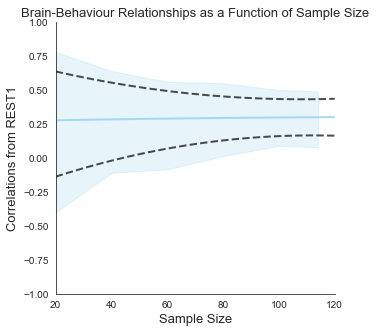

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

#plt.xlim(bootstrap_results_REST1["SAMPLES"].min(), bootstrap_results_REST1["SAMPLES"].max())
plt.xlim(20, 120)
plt.ylim(-1.0, 1.0)

for d, ls, c in zip(bootstrap_results_REST1["METHOD"].unique(), ["", "", "-", "--", "--"], ["skyblue", "skyblue", "skyblue", "k", "k"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = bootstrap_results_REST1.loc[bootstrap_results_REST1.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.7}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

plt.fill_between(bootstrap_results_REST1["SAMPLES"].unique(), bootstrap_results_REST1[bootstrap_results_REST1["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 bootstrap_results_REST1[bootstrap_results_REST1["METHOD"] == "MAX"]["COEFFICIENTS"],
                 color='skyblue', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("Correlations from REST1", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()


Compare standard and bootstrap results

In [66]:
compare_bootstrap_results_REST = pd.read_excel('/Users/jivesh/Downloads/last_bootstrap.xlsx', sheet_name = 'COMPARE_REST_MINTR20')
compare_bootstrap_results_REST.head(n = 10)


,SAMPLES,METHOD,COEFFICIENTS
0,20,LCI_Standard,0.039
1,40,LCI_Standard,0.230
2,60,LCI_Standard,0.290
3,80,LCI_Standard,0.350
4,100,LCI_Standard,0.380
5,114,LCI_Standard,0.440
6,20,LCI_Bootstrap,-0.160
7,40,LCI_Bootstrap,0.025
8,60,LCI_Bootstrap,0.061
9,80,LCI_Bootstrap,0.098


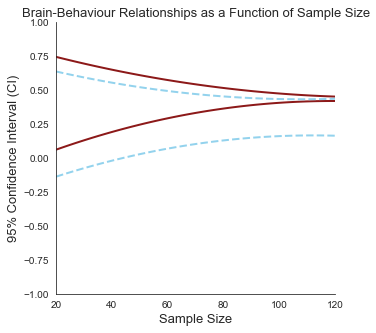

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

#plt.xlim(bootstrap_results_REST1["SAMPLES"].min(), bootstrap_results_REST1["SAMPLES"].max())
plt.xlim(20, 120)
plt.ylim(-1.0, 1.0)

for d, ls, c in zip(compare_bootstrap_results_REST["METHOD"].unique(), ["-", "--", "-", "--"], ["maroon", "skyblue", "maroon", "skyblue"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = compare_bootstrap_results_REST.loc[compare_bootstrap_results_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.9}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

#plt.fill_between(compare_bootstrap_results_REST["SAMPLES"].unique(), compare_bootstrap_results_REST[compare_bootstrap_results_REST["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 #compare_bootstrap_results_REST[compare_bootstrap_results_REST["METHOD"] == "MAX"]["COEFFICIENTS"],
                 #color='palevioletred', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("95% Confidence Interval (CI)", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()


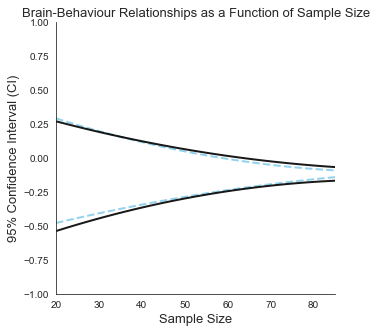

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

#plt.xlim(bootstrap_results_REST1["SAMPLES"].min(), bootstrap_results_REST1["SAMPLES"].max())
plt.xlim(20, 85)
plt.ylim(-1.0, 1.0)

for d, ls, c in zip(compare_bootstrap_results_REST["METHOD"].unique(), ["--", "--", "-", "-"], ["skyblue", "skyblue", "black", "black"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = compare_bootstrap_results_REST.loc[compare_bootstrap_results_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.9}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

#plt.fill_between(compare_bootstrap_results_REST["SAMPLES"].unique(), compare_bootstrap_results_REST[compare_bootstrap_results_REST["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 #compare_bootstrap_results_REST[compare_bootstrap_results_REST["METHOD"] == "MAX"]["COEFFICIENTS"],
                 #color='palevioletred', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("95% Confidence Interval (CI)", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()



In [11]:
#Date: 01/11/2021
#Authors: Jivesh Ramduny & Clare Kelly
#Location: Imaging Mind Architecture Lab, Trinity College Dublin

import os
import glob
import os.path as path
import pandas as pd
import numpy as np
import statsmodels.api as sm

#input directory for the 268 ROIs timeseries derived from Shen parcellation
rs_datapath = '/Users/jivesh/Downloads/TSFD004/*_HBN_268Parcels_rest_run_1.txt'
mv_datapath = '/Users/jivesh/Downloads/TSFD004/*_HBN_268Parcels_rest_run_2.txt'

rsfilename_list = np.sort(glob.glob(rs_datapath))
mvfilename_list = np.sort(glob.glob(mv_datapath))

#initialise an empty list to store all subjects timeseries for Sessions 1
rs_non_zero_roi = []
rsfMRI_timeseries = []
rsfMRI_timeseries_2d = []
rsfMRI_timeseries_corr = []

#initialise an empty list to store all subjects timeseries for Sessions 2
mv_non_zero_roi = []
mvfMRI_timeseries = []
mvfMRI_timeseries_2d = []
mvfMRI_timeseries_corr = []

rssubj_exclusion = []
mvsubj_exclusion = []
all_unique_contaminated_indices = []
mvall_unique_contaminated_indices = []

best_timepoints_size_s1 = []
best_timepoints_size_s2 = []

#iterate through the ROIs timeseries of each subject for Session 1
for rsfilename in rsfilename_list:

    rs_corr_shen = np.transpose(np.loadtxt(rsfilename))
    #append the ROI timeseries for each subject to a list
    rsfMRI_timeseries.append(rs_corr_shen)
    #find the subject-wise indices whose ROI timeseries have a value of 0
    rs_non_zero = np.where(np.any(rs_corr_shen == 0, axis = 1))
    #append the subject-wise indices to a list
    rs_non_zero_roi = np.concatenate((rs_non_zero_roi, rs_non_zero), axis = None)

#convert the appended list of all the subjects' timeseries to an array
rsfMRI_timeseries_to_array = np.asarray(rsfMRI_timeseries)

#iterate through the ROIs timeseries of each subject for Session 2
for mvfilename in mvfilename_list:

    mv_corr_shen = np.transpose(np.loadtxt(mvfilename))
    #append the ROI timeseries for each subject to a list
    mvfMRI_timeseries.append(mv_corr_shen)
    #find the subject-wise indices whose ROI timeseries have a value of 0
    mv_non_zero = np.where(np.any(mv_corr_shen == 0, axis = 1))
    #append the subject-wise indices to a list
    mv_non_zero_roi = np.concatenate((mv_non_zero_roi, mv_non_zero), axis = None)

#convert the appended list of all the subjects' timeseries to an array
mvfMRI_timeseries_to_array = np.asarray(mvfMRI_timeseries)

#append all subject-wise indices whose ROI timeseries contain a value of 0 for Session 1 & 2
all_indices_s1_s2 = np.concatenate((rs_non_zero_roi, mv_non_zero_roi), axis = None)
#find all the unique indices whose ROI timeseries contain a value of 0
find_unique_indices = np.unique(all_indices_s1_s2)
find_unique_indices_int = find_unique_indices.astype(int)

#remove all the rows whose ROI timseries contain a value of 0 based on the list of unique indices for Session 1
rsfMRI_nonzero_timeseries = np.delete(rsfMRI_timeseries_to_array, find_unique_indices_int, axis = 1)

rsfMRI_nonzero_timeseries = np.delete(rsfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)

#sanity check to verify the content and size of the resulting nonzero ROI timeseries
print(rsfMRI_nonzero_timeseries.shape)

#remove all the rows whose ROI timseries contain a value of 0 based on the list of unique indices for Session 2
mvfMRI_nonzero_timeseries = np.delete(mvfMRI_timeseries_to_array, find_unique_indices_int, axis = 1)

mvfMRI_nonzero_timeseries = np.delete(mvfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)

#sanity check to verify the content and size of the resulting nonzero ROI timeseries
print(mvfMRI_nonzero_timeseries.shape)

for rs_sub in range(0, rsfMRI_nonzero_timeseries.shape[0]):

    #copy the subject-wise ROI timeseries to a temporary 2D array for Session 1
    rsfMRI_timeseries_2d = rsfMRI_nonzero_timeseries[rs_sub, :, :].copy()

    #compute Pearson's correlation coefficient for Session 1
    rsfMRI_corr = np.corrcoef(rsfMRI_timeseries_2d)

    #truncate correlation matrix to select upper triangular matrix for Session 1
    rsfMRI_corr_shen = rsfMRI_corr.shape[0]
    arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
    trunc_rsfMRI_corr_shen = rsfMRI_corr[arange_rsfMRI_corr, diag]

    #append the truncated correlation matrix of all subjects to the list
    rsfMRI_timeseries_corr.append(trunc_rsfMRI_corr_shen)

#convert the list to an array for Session 1
trunc_rsfMRI_corr_to_array = np.asarray(rsfMRI_timeseries_corr)

print(trunc_rsfMRI_corr_to_array.shape)

#within_session_FC = np.mean(np.array([trunc_rsfMRI_corr_to_array, trunc_mvfMRI_corr_to_array]), axis = 0)
within_session_rsFC = trunc_rsfMRI_corr_to_array

(113, 211, 375)
(113, 211, 375)
(113, 22155)


In [12]:
for mv_sub in range(0, mvfMRI_nonzero_timeseries.shape[0]):

    #copy the subject-wise ROI timeseries to a temporary 2D array for Session 2
    mvfMRI_timeseries_2d = mvfMRI_nonzero_timeseries[mv_sub, :, :].copy()

    #compute Pearson's correlation coefficient for Session 2
    mvfMRI_corr = np.corrcoef(mvfMRI_timeseries_2d)

    #truncate correlation matrix to select upper triangular matrix for Session 2
    mvfMRI_corr_shen = mvfMRI_corr.shape[0]
    arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
    trunc_mvfMRI_corr_shen = mvfMRI_corr[arange_mvfMRI_corr, diag]

    #append the truncated correlation matrix of all subjects to the list
    mvfMRI_timeseries_corr.append(trunc_mvfMRI_corr_shen)

#convert the list to an array for Session 1
trunc_mvfMRI_corr_to_array = np.asarray(mvfMRI_timeseries_corr)

print(trunc_mvfMRI_corr_to_array.shape)

#within_session_FC = np.mean(np.array([trunc_rsfMRI_corr_to_array, trunc_mvfMRI_corr_to_array]), axis = 0)
within_session_mvFC = trunc_mvfMRI_corr_to_array


(113, 22155)


In [13]:
model_pval = []
model_coef = []

for edge in range(0, within_session_rsFC.shape[1]):
    
    behav_new = behav_df[['AGE', 'SEX', 'REST1_FD']]
    behav_new = pd.DataFrame(np.delete(np.array(behav_new), unique_subj_exclusion, axis = 0))
    behav_new.columns = ['AGE', 'SEX', 'REST1_FD']
    behav_new['FC'] = within_session_rsFC[:, edge]
    model = pg.partial_corr(data = behav_new, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model_pval.append(model['p-val'])
    model_coef.append(model['r'])
    

In [14]:
import statsmodels.stats.multitest as mc
corr_pval = mc.multipletests(np.array(model_pval).flatten(), alpha = 0.05, method = 'fdr_bh')
corr_pval


(array([False, False, False, ..., False, False, False]),
 array([0.86965731, 0.86471797, 0.89336927, ..., 0.64507657, 0.27157239,
        0.93101719]),
 2.315199052582706e-06,
 2.2568269013766643e-06)

In [15]:
pcorr_indices = np.where(corr_pval[1] <= 0.05)
np.array(pcorr_indices).shape[1]


14

In [16]:
REST1_coef = np.array(np.take(model_coef, pcorr_indices)).flatten()
REST1_pval = np.array(np.take(model_pval, pcorr_indices)).flatten()
max_corr_edge = REST1_coef.argmax()
max_corr_edge

best_edge = np.array(np.where(model_coef == REST1_coef[max_corr_edge])).squeeze()[0]
best_edge


12057

In [17]:
numROI = rsfMRI_nonzero_timeseries.shape[1]

A = np.arange(numROI * numROI).reshape(numROI, numROI)
A2 = np.arange(numROI * numROI).reshape(numROI, numROI)
np.fill_diagonal(A, 1)

B = A[np.triu_indices(numROI, k = 1)]
ROI_dimx = np.where(A2 == B[best_edge])
rsfMRI_bestroi_nonzero_timeseries = np.take(rsfMRI_nonzero_timeseries, ROI_dimx, axis = 1).squeeze()
mvfMRI_bestroi_nonzero_timeseries = np.take(mvfMRI_nonzero_timeseries, ROI_dimx, axis = 1).squeeze()

print(A)
print(rsfMRI_bestroi_nonzero_timeseries.shape)
print(mvfMRI_bestroi_nonzero_timeseries.shape)



[[    1     1     2 ...   208   209   210]
 [  211     1   213 ...   419   420   421]
 [  422   423     1 ...   630   631   632]
 ...
 [43888 43889 43890 ...     1 44097 44098]
 [44099 44100 44101 ... 44307     1 44309]
 [44310 44311 44312 ... 44518 44519     1]]
(113, 2, 375)
(113, 2, 375)


In [19]:
subjects = 20
epochs = 500

all_rssamples = []
all_mvsamples = []
edges = ((rsfMRI_bestroi_nonzero_timeseries.shape[1] * rsfMRI_bestroi_nonzero_timeseries.shape[1]) - rsfMRI_bestroi_nonzero_timeseries.shape[1]) // 2

rsbootstrap_rsfMRI_corr = np.zeros((epochs, subjects))
mvbootstrap_rsfMRI_corr = np.zeros((epochs, subjects))

for epoch in range(epochs):
    
    samples = np.random.choice(rsfMRI_bestroi_nonzero_timeseries.shape[0], subjects, replace = False)
    rsbootstrap_samples = np.take(rsfMRI_bestroi_nonzero_timeseries, samples, axis = 0)
    all_rssamples.append(samples)
    
    for sub_s1 in range(rsbootstrap_samples.shape[0]):
        rsbootstrap_timeseries_2d = rsbootstrap_samples[sub_s1, :, :].copy()
        rsbootstrap_corr_matrix = np.corrcoef(rsbootstrap_timeseries_2d)
        
        rsbootstrap_corr_shen = rsbootstrap_corr_matrix.shape[0]
        arange_rsbootstrap_corr, diag = np.triu_indices(rsbootstrap_corr_shen, 1)
        trunc_rsbootstrap_corr = rsbootstrap_corr_matrix[arange_rsbootstrap_corr, diag]
        rsbootstrap_rsfMRI_corr[epoch, sub_s1] = trunc_rsbootstrap_corr
        
for epoch in range(epochs):
    
    samples = np.random.choice(mvfMRI_bestroi_nonzero_timeseries.shape[0], subjects, replace = False)
    mvbootstrap_samples = np.take(mvfMRI_bestroi_nonzero_timeseries, samples, axis = 0)
    all_mvsamples.append(samples)
    
    for sub_s2 in range(mvbootstrap_samples.shape[0]):
        mvbootstrap_timeseries_2d = mvbootstrap_samples[sub_s2, :, :].copy()
        mvbootstrap_corr_matrix = np.corrcoef(mvbootstrap_timeseries_2d)
        
        mvbootstrap_corr_shen = mvbootstrap_corr_matrix.shape[0]
        arange_mvbootstrap_corr, diag = np.triu_indices(mvbootstrap_corr_shen, 1)
        trunc_mvbootstrap_corr = mvbootstrap_corr_matrix[arange_mvbootstrap_corr, diag]
        mvbootstrap_rsfMRI_corr[epoch, sub_s2] = trunc_mvbootstrap_corr

print(rsbootstrap_rsfMRI_corr.shape)
print(mvbootstrap_rsfMRI_corr.shape)


(500, 20)
(500, 20)


In [26]:
model2_pval = []
model2_coef = []

for epoch in range(epochs):
    
    behav2 = behav_df[['AGE', 'SEX', 'REST1_FD']]
    
    behav2 = pd.DataFrame(np.take(np.array(behav2), all_rssamples[epoch], axis = 0))
    behav2.columns = ['AGE', 'SEX', 'REST1_FD']
    
    behav2['FC'] = rsbootstrap_rsfMRI_corr[epoch, :]
    bootstrap_model = pg.partial_corr(data = behav2, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model2_pval.append(bootstrap_model['p-val'])
    model2_coef.append(bootstrap_model['r'])
    

(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)


LinAlgError: SVD did not converge in Linear Least Squares

In [62]:
model2_pval = np.array(model2_pval)
model2_coef = np.array(model2_coef)

min_coef = model2_coef.min()
print("min coef:" + str(min_coef))

max_coef = model2_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model2_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model2_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model2_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:-0.29774436090225564
max coef:0.7744360902255639
mean coef:0.38876691729323304
lower ci:-0.0008646616541353378
upper ci:0.7293233082706766


Calculate correlations based on the subjects that have remained in the sample in the bootstrapping method

In [18]:
#Date: 01/11/2021
#Authors: Jivesh Ramduny & Clare Kelly
#Location: Imaging Mind Architecture Lab, Trinity College Dublin

import os
import glob
import os.path as path
import pandas as pd
import numpy as np
import statsmodels.api as sm

#input directory for the 268 ROIs timeseries derived from Shen parcellation
rs_datapath = '/Users/jivesh/Downloads/TSFD004/*_HBN_268Parcels_rest_run_1.txt'
mv_datapath = '/Users/jivesh/Downloads/TSFD004/*_HBN_268Parcels_rest_run_2.txt'

rsfilename_list = np.sort(glob.glob(rs_datapath))
mvfilename_list = np.sort(glob.glob(mv_datapath))

#initialise an empty list to store all subjects timeseries for Sessions 1
rs_non_zero_roi = []
rsfMRI_timeseries = []
rsfMRI_timeseries_2d = []
rsfMRI_timeseries_corr = []

#initialise an empty list to store all subjects timeseries for Sessions 2
mv_non_zero_roi = []
mvfMRI_timeseries = []
mvfMRI_timeseries_2d = []
mvfMRI_timeseries_corr = []

rssubj_exclusion = []
mvsubj_exclusion = []
all_unique_contaminated_indices = []
mvall_unique_contaminated_indices = []

best_timepoints_size_s1 = []
best_timepoints_size_s2 = []

#iterate through the ROIs timeseries of each subject for Session 1
for rsfilename in rsfilename_list:

    rs_corr_shen = np.transpose(np.loadtxt(rsfilename))
    #append the ROI timeseries for each subject to a list
    rsfMRI_timeseries.append(rs_corr_shen)
    #find the subject-wise indices whose ROI timeseries have a value of 0
    rs_non_zero = np.where(np.any(rs_corr_shen == 0, axis = 1))
    #append the subject-wise indices to a list
    rs_non_zero_roi = np.concatenate((rs_non_zero_roi, rs_non_zero), axis = None)

#convert the appended list of all the subjects' timeseries to an array
rsfMRI_timeseries_to_array = np.asarray(rsfMRI_timeseries)

#iterate through the ROIs timeseries of each subject for Session 2
for mvfilename in mvfilename_list:

    mv_corr_shen = np.transpose(np.loadtxt(mvfilename))
    #append the ROI timeseries for each subject to a list
    mvfMRI_timeseries.append(mv_corr_shen)
    #find the subject-wise indices whose ROI timeseries have a value of 0
    mv_non_zero = np.where(np.any(mv_corr_shen == 0, axis = 1))
    #append the subject-wise indices to a list
    mv_non_zero_roi = np.concatenate((mv_non_zero_roi, mv_non_zero), axis = None)

#convert the appended list of all the subjects' timeseries to an array
mvfMRI_timeseries_to_array = np.asarray(mvfMRI_timeseries)

#append all subject-wise indices whose ROI timeseries contain a value of 0 for Session 1 & 2
all_indices_s1_s2 = np.concatenate((rs_non_zero_roi, mv_non_zero_roi), axis = None)
#find all the unique indices whose ROI timeseries contain a value of 0
find_unique_indices = np.unique(all_indices_s1_s2)
find_unique_indices_int = find_unique_indices.astype(int)

#remove all the rows whose ROI timseries contain a value of 0 based on the list of unique indices for Session 1
rsfMRI_nonzero_timeseries = np.delete(rsfMRI_timeseries_to_array, find_unique_indices_int, axis = 1)

rsfMRI_nonzero_timeseries = np.delete(rsfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)

#sanity check to verify the content and size of the resulting nonzero ROI timeseries
print(rsfMRI_nonzero_timeseries.shape)

#remove all the rows whose ROI timseries contain a value of 0 based on the list of unique indices for Session 2
mvfMRI_nonzero_timeseries = np.delete(mvfMRI_timeseries_to_array, find_unique_indices_int, axis = 1)

mvfMRI_nonzero_timeseries = np.delete(mvfMRI_nonzero_timeseries, unique_subj_exclusion, axis = 0)

#sanity check to verify the content and size of the resulting nonzero ROI timeseries
print(mvfMRI_nonzero_timeseries.shape)

for rs_sub in range(rsfMRI_nonzero_timeseries.shape[0]):

    #copy the subject-wise ROI timeseries to a temporary 2D array for Session 1
    rsfMRI_timeseries_2d = rsfMRI_nonzero_timeseries[rs_sub, :, :].copy()

    #compute Pearson's correlation coefficient for Session 1
    rsfMRI_corr = np.corrcoef(rsfMRI_timeseries_2d)

    #truncate correlation matrix to select upper triangular matrix for Session 1
    rsfMRI_corr_shen = rsfMRI_corr.shape[0]
    arange_rsfMRI_corr, diag = np.triu_indices(rsfMRI_corr_shen, 1)
    trunc_rsfMRI_corr_shen = rsfMRI_corr[arange_rsfMRI_corr, diag]

    #append the truncated correlation matrix of all subjects to the list
    rsfMRI_timeseries_corr.append(trunc_rsfMRI_corr_shen)

#convert the list to an array for Session 1
trunc_rsfMRI_corr_to_array = np.asarray(rsfMRI_timeseries_corr)

print(trunc_rsfMRI_corr_to_array.shape)

#within_session_FC = np.mean(np.array([trunc_rsfMRI_corr_to_array, trunc_mvfMRI_corr_to_array]), axis = 0)
within_session_rsFC = trunc_rsfMRI_corr_to_array

for mv_sub in range(mvfMRI_nonzero_timeseries.shape[0]):

    #copy the subject-wise ROI timeseries to a temporary 2D array for Session 2
    mvfMRI_timeseries_2d = mvfMRI_nonzero_timeseries[mv_sub, :, :].copy()

    #compute Pearson's correlation coefficient for Session 2
    mvfMRI_corr = np.corrcoef(mvfMRI_timeseries_2d)

    #truncate correlation matrix to select upper triangular matrix for Session 2
    mvfMRI_corr_shen = mvfMRI_corr.shape[0]
    arange_mvfMRI_corr, diag = np.triu_indices(mvfMRI_corr_shen, 1)
    trunc_mvfMRI_corr_shen = mvfMRI_corr[arange_mvfMRI_corr, diag]

    #append the truncated correlation matrix of all subjects to the list
    mvfMRI_timeseries_corr.append(trunc_mvfMRI_corr_shen)

#convert the list to an array for Session 1
trunc_mvfMRI_corr_to_array = np.asarray(mvfMRI_timeseries_corr)

print(trunc_mvfMRI_corr_to_array.shape)

#within_session_FC = np.mean(np.array([trunc_rsfMRI_corr_to_array, trunc_mvfMRI_corr_to_array]), axis = 0)
within_session_mvFC = trunc_mvfMRI_corr_to_array


(81, 211, 375)
(81, 211, 375)
(81, 22155)
(81, 22155)


In [19]:
#transpose the array to ease further computation for Session 1
trans_rsfMRI_corr = np.transpose(trunc_rsfMRI_corr_to_array)

#transpose the array to ease further computation for Session 2
trans_mvfMRI_corr = np.transpose(trunc_mvfMRI_corr_to_array)

#compute columnwise pearson's correlation matrix between Session 1 and Session 2
trans_rsfMRI_corr = (trans_rsfMRI_corr - trans_rsfMRI_corr.mean(axis = 0)) / trans_rsfMRI_corr.std(axis = 0)
trans_mvfMRI_corr = (trans_mvfMRI_corr - trans_mvfMRI_corr.mean(axis = 0)) / trans_mvfMRI_corr.std(axis = 0)
rs_mv_corr = np.dot(trans_rsfMRI_corr.T, trans_mvfMRI_corr) / trans_rsfMRI_corr.shape[0]

#sanity check to verify the size and content of the correlation matrix
print(rs_mv_corr.shape); print(rs_mv_corr)

#extract the diagonal values of the final correlation matrix
diag = np.diag(rs_mv_corr)

#extract the maximum value in each row of the final correlation matrix
max_corr = np.amax(rs_mv_corr, axis = 1)

#ID is based on a binary system where each diagonal value is compared with the
#maximum value of that row in the final correlation matrix. We expect that the
#diagnoal value is greater than or equal to the maximum value of each row to
#allow successful identification
diag_to_array = np.array(diag)
max_corr_to_array = np.array(max_corr)
BID = np.greater_equal(diag_to_array, max_corr_to_array)

print(BID)

#success rate is defined as the total number of positive identifications divided
#by the total number of subjects
success_rate_BID = np.sum(BID)/(BID.shape)
print(success_rate_BID)


(81, 81)
[[0.6103403  0.39970912 0.3966607  ... 0.31173062 0.4361274  0.39008818]
 [0.26047269 0.74633598 0.35165932 ... 0.34370308 0.41951081 0.46573201]
 [0.41021549 0.43436071 0.6643962  ... 0.3281306  0.51593379 0.44089552]
 ...
 [0.41594233 0.40005342 0.41983736 ... 0.6508089  0.51190889 0.47098813]
 [0.44822014 0.4018118  0.52205305 ... 0.35048214 0.66423748 0.44920666]
 [0.41820658 0.34719254 0.40120001 ... 0.34624266 0.40166408 0.57981052]]
[ True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True False  True  True  True False  True False
  True False False  True False False  True  True  True False  True False
  True False  True False  True  True  True  True  True  True  True  True
  True  True  True False False  True  True False  True  True  True  True
 False False  True  True  True False  True  True  True]
[0.7654321]


In [10]:
model_pval = []
model_coef = []

behav_new = behav_df[['AGE', 'SEX', 'REST1_FD']]
behav_new_df = pd.DataFrame(np.delete(np.array(behav_new), unique_subj_exclusion, axis = 0))
behav_new_df.columns = ['AGE', 'SEX', 'REST1_FD']

for edge in range(within_session_rsFC.shape[1]):
    
    behav_new_df['FC'] = within_session_rsFC[:, edge]
    model = pg.partial_corr(data = behav_new_df, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model_pval.append(model['p-val'])
    model_coef.append(model['r'])


In [11]:
import statsmodels.stats.multitest as mc
corr_pval = mc.multipletests(np.array(model_pval).flatten(), alpha = 0.05, method = 'fdr_bh')
corr_pval


(array([False, False, False, ..., False, False, False]),
 array([0.96721531, 0.75737998, 0.93238542, ..., 0.88832305, 0.65159845,
        0.88467779]),
 2.315199052582706e-06,
 2.2568269013766643e-06)

In [12]:
pcorr_indices = np.where(corr_pval[1] <= 0.05)
np.array(pcorr_indices).shape[1]


6

In [13]:
REST1_coef = np.array(np.take(model_coef, pcorr_indices)).flatten()
REST1_pval = np.array(np.take(model_pval, pcorr_indices)).flatten()
max_corr_edge = REST1_coef.argmax()
max_corr_edge

best_edge = np.array(np.where(model_coef == REST1_coef[max_corr_edge])).squeeze()[0]
best_edge


1826

In [14]:
numROI = rsfMRI_nonzero_timeseries.shape[1]

A = np.arange(numROI * numROI).reshape(numROI, numROI)
A2 = np.arange(numROI * numROI).reshape(numROI, numROI)
np.fill_diagonal(A, 1)

B = A[np.triu_indices(numROI, k = 1)]
ROI_dimx = np.where(A2 == B[best_edge])
rsfMRI_bestroi_nonzero_timeseries = np.take(rsfMRI_nonzero_timeseries, ROI_dimx, axis = 1).squeeze()
mvfMRI_bestroi_nonzero_timeseries = np.take(mvfMRI_nonzero_timeseries, ROI_dimx, axis = 1).squeeze()

print(A)
print(rsfMRI_bestroi_nonzero_timeseries.shape)
print(mvfMRI_bestroi_nonzero_timeseries.shape)

[[    1     1     2 ...   208   209   210]
 [  211     1   213 ...   419   420   421]
 [  422   423     1 ...   630   631   632]
 ...
 [43888 43889 43890 ...     1 44097 44098]
 [44099 44100 44101 ... 44307     1 44309]
 [44310 44311 44312 ... 44518 44519     1]]
(81, 2, 375)
(81, 2, 375)


In [27]:
subjects = 81
epochs = 500

all_rssamples = []
all_mvsamples = []
edges = ((rsfMRI_bestroi_nonzero_timeseries.shape[1] * rsfMRI_bestroi_nonzero_timeseries.shape[1]) - rsfMRI_bestroi_nonzero_timeseries.shape[1]) // 2

rsbootstrap_rsfMRI_corr = np.zeros((epochs, subjects))
mvbootstrap_rsfMRI_corr = np.zeros((epochs, subjects))

for epoch in range(epochs):
    
    samples = np.random.choice(rsfMRI_bestroi_nonzero_timeseries.shape[0], subjects, replace = False)
    rsbootstrap_samples = np.take(rsfMRI_bestroi_nonzero_timeseries, samples, axis = 0)
    all_rssamples.append(samples)
    
    for sub_s1 in range(rsbootstrap_samples.shape[0]):
        rsbootstrap_timeseries_2d = rsbootstrap_samples[sub_s1, :, :].copy()
        rsbootstrap_corr_matrix = np.corrcoef(rsbootstrap_timeseries_2d)
        
        rsbootstrap_corr_shen = rsbootstrap_corr_matrix.shape[0]
        arange_rsbootstrap_corr, diag = np.triu_indices(rsbootstrap_corr_shen, 1)
        trunc_rsbootstrap_corr = rsbootstrap_corr_matrix[arange_rsbootstrap_corr, diag]
        rsbootstrap_rsfMRI_corr[epoch, sub_s1] = trunc_rsbootstrap_corr
        
for epoch in range(epochs):
    
    samples = np.random.choice(mvfMRI_bestroi_nonzero_timeseries.shape[0], subjects, replace = False)
    mvbootstrap_samples = np.take(mvfMRI_bestroi_nonzero_timeseries, samples, axis = 0)
    all_mvsamples.append(samples)
    
    for sub_s2 in range(mvbootstrap_samples.shape[0]):
        mvbootstrap_timeseries_2d = mvbootstrap_samples[sub_s2, :, :].copy()
        mvbootstrap_corr_matrix = np.corrcoef(mvbootstrap_timeseries_2d)
        
        mvbootstrap_corr_shen = mvbootstrap_corr_matrix.shape[0]
        arange_mvbootstrap_corr, diag = np.triu_indices(mvbootstrap_corr_shen, 1)
        trunc_mvbootstrap_corr = mvbootstrap_corr_matrix[arange_mvbootstrap_corr, diag]
        mvbootstrap_rsfMRI_corr[epoch, sub_s2] = trunc_mvbootstrap_corr

print(rsbootstrap_rsfMRI_corr.shape)
print(mvbootstrap_rsfMRI_corr.shape)


(500, 81)
(500, 81)


In [28]:
model2_pval = []
model2_coef = []

for epoch in range(epochs):
    
    behav2 = behav_new_df[['AGE', 'SEX', 'REST1_FD']]
    behav2 = pd.DataFrame(np.take(np.array(behav2), all_rssamples[epoch], axis = 0))
    behav2.columns = ['AGE', 'SEX', 'REST1_FD']
    
    behav2['FC'] = rsbootstrap_rsfMRI_corr[epoch, :]
    
    bootstrap_model = pg.partial_corr(data = behav2, x = 'AGE', y = 'FC', covar = ['SEX', 'REST1_FD'], method = 'spearman')
    model2_pval.append(bootstrap_model['p-val'])
    model2_coef.append(bootstrap_model['r'])
    

In [29]:
model2_pval = np.array(model2_pval)
model2_coef = np.array(model2_coef)

min_coef = model2_coef.min()
print("min coef:" + str(min_coef))

max_coef = model2_coef.max()
print("max coef:" + str(max_coef))

mean_coef = model2_coef.mean()
print("mean coef:" + str(mean_coef))

lower_ci = np.percentile(model2_coef, q = 2.5)
print("lower ci:" + str(lower_ci))

upper_ci = np.percentile(model2_coef, q = 97.5)
print("upper ci:" + str(upper_ci))


min coef:0.5414182475158085
max coef:0.5414182475158085
mean coef:0.5414182475158086
lower ci:0.5414182475158085
upper ci:0.5414182475158085


In [32]:
compare_bootstrap_results_REST = pd.read_excel('/Users/jivesh/Downloads/bootstrap_results_FD004_bestROI.xlsx', sheet_name = 'COMPARE_REST1_MINTR100')
compare_bootstrap_results_REST.head(n = 10)


,SAMPLES,METHOD,COEFFICIENTS
0,20,LCI_Standard,0.039
1,40,LCI_Standard,0.230
2,60,LCI_Standard,0.290
3,80,LCI_Standard,0.350
4,100,LCI_Standard,0.380
5,114,LCI_Standard,0.440
6,20,LCI_Bootstrap,0.036
7,40,LCI_Bootstrap,0.230
8,60,LCI_Bootstrap,0.300
9,80,LCI_Bootstrap,0.340


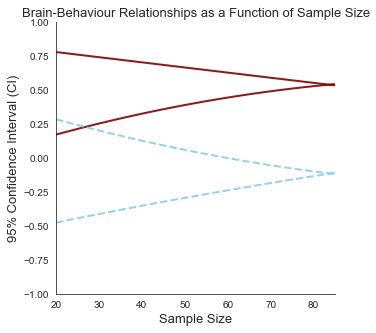

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
_, ax = plt.subplots(figsize=(5, 5))

#plt.xlim(bootstrap_results_REST1["SAMPLES"].min(), bootstrap_results_REST1["SAMPLES"].max())
plt.xlim(20, 85)
plt.ylim(-1.0, 1.0)

for d, ls, c in zip(compare_bootstrap_results_REST["METHOD"].unique(), ["-", "--", "-", "--"], ["maroon", "skyblue", "maroon", "skyblue"]):
    
    sns.regplot(x = "SAMPLES", y = "COEFFICIENTS", data = compare_bootstrap_results_REST.loc[compare_bootstrap_results_REST.METHOD == d], 
                line_kws={"ls":ls, "lw":2, "alpha":0.9}, ax = ax, label = d,
                order = 2, color = c, truncate = False, ci = None, scatter = False)

#plt.fill_between(compare_bootstrap_results_REST["SAMPLES"].unique(), compare_bootstrap_results_REST[compare_bootstrap_results_REST["METHOD"] == "MIN"]["COEFFICIENTS"], 
                 #compare_bootstrap_results_REST[compare_bootstrap_results_REST["METHOD"] == "MAX"]["COEFFICIENTS"],
                 #color='palevioletred', alpha = 0.2)    

plt.xlabel("Sample Size", size = 13)
plt.ylabel("95% Confidence Interval (CI)", size = 13)
plt.title("Brain-Behaviour Relationships as a Function of Sample Size", size = 13)
sns.despine()


In [58]:
from sklearn import metrics
X = [20, 40, 60, 80, 100, 114]
Y = [0.64, 0.55, 0.48, 0.47, 0.43, 0.43]
metrics.auc(X, Y)

46.72

In [59]:
46.72 - (6.16)

40.56